# ->Load modules

In [1]:
# Timestamps range
# 5-7 pre-morning peak,7-10 morning peak, 10-16 morning off-peak, 
# 16-17 pre-evening peak, 17-19 evening peak,19-22 late evening peak, 22 evening off-peak,
# The above 7 time intervals will be transformed in to a 0-6 catagorical number, then turned into one-hots
tint_dict={0:'pre-morning peak',1:'morning peak',2:'morning off-peak',3:'pre-evening peak',4:'evening peak',5:'late evening peak',6:'evening off-peak'}

import numpy as np
import pandas as pd
import csv
import time,datetime
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import pickle
from sklearn.externals import joblib
from scipy import spatial
from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
import sklearn
import scipy
import seaborn as sns
from collections import Counter
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input
import keras
import keras.backend as K
from keras_tqdm import TQDMNotebookCallback

import tensorflow as tf
%matplotlib inline

#写一个LossHistory类，保存loss和acc
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
        
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
            # deviation
            #plt.plot(iters, self.dev_metric[loss_type], 'y', label='deviation')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

MRTStops=pd.read_csv('MRTStops_Geo_POI_Interchange_Lines_Handmade.csv')
MRTLineNames=['NS','EW','NE','CC','CE','DT','TE','JS','JE','BP','CG','JW','PW','PE','SW','SE','STC','PTC']
stationDict=MRTStops['MRTStopsName']
stationDict=stationDict.to_dict()
stationDict_re=dict(zip(stationDict.values(),stationDict.keys()))

def getFeatMatRowIdx(MRTStopsName,interval):
    staNum=stationDict_re[MRTStopsName]
    return staNum+interval*len(stationDict_re)

def getWeirdStations(num_flowmat):
    if num_flowmat<2:
        return "Long or Lat"
    else:
        num_flowmat=num_flowmat-2 # long and lat
        if num_flowmat<122:
            return stationDict[num_flowmat]
        elif 122<=num_flowmat<244:
            return stationDict[num_flowmat-122]
        else:
            return "Not in stopsDict, should be time and day"

def getStationLineNames(stn_num):
    line_dict={}
    lines=[]
    dummy=[]
    for line in MRTLineNames:
        eq1='line_dict["'+line+'"]="'+line+'"'
        eq2=line+'=MRTStops[MRTStops.'+line+'==1].index'
        exec(eq1)
        exec(eq2)
        eq3= 'lines.append( line_dict["'+line+'"]  ) if stn_num in '+line+' else dummy.append(1)'
        exec(eq3)
    return lines
          
def getStationNames(stn_num):
    res=[]
    lines=[]
    for i in range(len(stn_num)):
        tmp=stn_num[i]%122
        res.append(stationDict[tmp])
        lines.append(getStationLineNames(tmp))
    return list(set(res)),res,lines

E:\Anaconda3_5\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Construct auto-encoder for dimension reduction among 7 time intervals(7 models)

In [3]:
# Construct dictionary for differnt time of the day
flowDict=joblib.load('flowMat_dict_onehot.asv')


mat_sta_id=np.eye(122)
for i in range(6):
    tmp=np.eye(122)
    mat_sta_id=np.row_stack((mat_sta_id,tmp))
del tmp


for tint in range(7):
    eq0='flowMat_tint_'+str(tint)+'=np.empty(shape=[0,373])' # The feature is 244+7 adding 122 dimension one-hot for station identification
    exec(eq0)

del tint,eq0

cnt=0
for day in ['0319','0320','0321','0322','0323','0324','0325']:
    eq1='flowMat_'+day+'=flowDict['+str(cnt)+']'
    eq2='tmp=np.column_stack((mat_sta_id,flowMat_'+day+ '[:,:-7]))'
    exec(eq1)
    exec(eq2)
    
    # flowMat has 122*7 rows, from Monday to Sunday
    flowMat_tint_0=np.append(flowMat_tint_0,tmp[0:122,:],axis=0)
    flowMat_tint_1=np.append(flowMat_tint_1,tmp[122:(122*2),:],axis=0)
    flowMat_tint_2=np.append(flowMat_tint_2,tmp[(122*2):(122*3),:],axis=0)
    flowMat_tint_3=np.append(flowMat_tint_3,tmp[(122*3):(122*4),:],axis=0)
    flowMat_tint_4=np.append(flowMat_tint_4,tmp[(122*4):(122*5),:],axis=0)
    flowMat_tint_5=np.append(flowMat_tint_5,tmp[(122*5):(122*6),:],axis=0)
    flowMat_tint_6=np.append(flowMat_tint_6,tmp[(122*6):(122*7),:],axis=0)
    
    cnt+=1
del cnt
flowDict_int={}
for i in range(7):
    eq3='flowDict_int['+str(i)+']=flowMat_tint_'+str(i)
    exec(eq3)
joblib.dump(flowDict_int,'flowMat_dict_tint_stn_onehot.asv')

# Begin to train 7 separate models 
# Take the first as example
flowDict_int=joblib.load('flowMat_dict_tint_stn_onehot.asv')
flowDict_tint=joblib.load('flowMat_dict_tint.asv')
train_data_tint_0=flowDict_int[0]
train_data_tint_1=flowDict_int[1]
train_data_tint_2=flowDict_int[2]

n_dim=np.shape(train_data_tint_0)[1]
n_samples=np.shape(train_data_tint_0)[0]
# Normalization

# Mean-std normalization ( with poor performance)
#norm_mean_0=np.mean(train_data_tint_0,axis=0)
#norm_std_0=np.std(train_data_tint_0,axis=0)
#train_data_tint_0=(train_data_tint_0-norm_mean_0)/norm_std_0
#train_data_tint_0=np.nan_to_num(train_data_tint_0)

# Max normalization
train_data_tint_0=flowDict_tint[0]
train_data_tint_0,norm_tint_ori_0=sklearn.preprocessing.normalize(train_data_tint_0,norm='max',return_norm=True,axis=0)

train_data_tint_1=flowDict_tint[1]
train_data_tint_1,norm_tint_ori_1=sklearn.preprocessing.normalize(train_data_tint_1,norm='max',return_norm=True,axis=0)

train_data_tint_2=flowDict_tint[2]
train_data_tint_2,norm_tint_ori_2=sklearn.preprocessing.normalize(train_data_tint_2,norm='max',return_norm=True,axis=0)

train_data_tint_3=flowDict_tint[3]
train_data_tint_3,norm_tint_ori_3=sklearn.preprocessing.normalize(train_data_tint_3,norm='max',return_norm=True,axis=0)

train_data_tint_4=flowDict_tint[4]
train_data_tint_4,norm_tint_ori_4=sklearn.preprocessing.normalize(train_data_tint_4,norm='max',return_norm=True,axis=0)

train_data_tint_5=flowDict_tint[5]
train_data_tint_5,norm_tint_ori_5=sklearn.preprocessing.normalize(train_data_tint_5,norm='max',return_norm=True,axis=0)

train_data_tint_6=flowDict_tint[6]
train_data_tint_6,norm_tint_ori_6=sklearn.preprocessing.normalize(train_data_tint_6,norm='max',return_norm=True,axis=0)

flowMat_dict=joblib.load('flowMat_dict_onehot.asv')
#train_data_test=tf.data.Dataset.from_tensor_slices(flowMat_dict[0])
#train_data_test=np.column_stack((mat_sta_id,flowMat_dict[0][:,:-7]))
train_data_test=(flowMat_dict[0])
train_data_test=np.column_stack((mat_sta_id,train_data_test))
norm_test=np.linalg.norm(train_data_test,ord=1,axis=0,keepdims=True)
train_data_test=train_data_test/norm_test
train_data_test[np.isnan(train_data_test)]=0
n_dim_test=np.shape(train_data_test)[1]
n_samples_test=np.shape(train_data_test)[0]

E:\Anaconda3_5\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


## Build Models

In [4]:
# Build the autoencoder model
#---- Hyper parameters
#K.set_value(sgd.lr,1e-6)

encoding_dim = 10
encode_layer1=256
encode_layer2=128
encode_layer3=64
encode_layer4=30

decode_layer1=encode_layer4
decode_layer2=encode_layer3
decode_layer3=encode_layer2
decode_layer4=encode_layer1

# this is our input placeholder
input_data = Input(shape=(n_dim,))
encode_decode_data=Input(shape=(encoding_dim,))

# encoder layers
encoded = Dense(encode_layer1, activation='relu')(input_data)
encoded = Dense(encode_layer2, activation='relu')(encoded)
encoded = Dense(encode_layer3, activation='relu')(encoded)
encoded = Dense(encode_layer4, activation='relu')(encoded)
encoder_output = Dense(encoding_dim)(encoded)

# decoder layers
decoded = Dense(decode_layer1, activation='relu')(encoder_output)
decoded = Dense(decode_layer2, activation='relu')(decoded)
decoded = Dense(decode_layer3, activation='relu')(decoded)
decoded = Dense(decode_layer4, activation='relu')(decoded)
decoded = Dense(n_dim, activation='tanh')(decoded)

# Decoder for saved models
decoder = Dense(decode_layer1, activation='relu')(encode_decode_data)
decoder = Dense(decode_layer2, activation='relu')(decoder)
decoder = Dense(decode_layer3, activation='relu')(decoder)
decoder = Dense(decode_layer4, activation='relu')(decoder)
decoder = Dense(n_dim, activation='tanh')(decoder)

In [5]:
autoencoder = Model(input=input_data, output=decoded)
# construct the encoder model for clustering and plotting
encoder = Model(input=input_data, output=encoder_output)

ada=keras.optimizers.Adagrad(lr=0.01, epsilon=1e-06)
history_tint_0 = LossHistory()

#def dev_metric(y_true, y_pred):
    #return K.mean(K.abs(y_pred-y_true))

# compile autoencoder
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(loss='mse',optimizer=ada)

# training
autoencoder.fit(train_data_tint_0, train_data_tint_0,
                nb_epoch=10**4,
                batch_size=128,
                shuffle=True,
                verbose=1,
                callbacks=[history_tint_0,TQDMNotebookCallback()])

history.loss_plot('epoch')
history.loss_plot('batch')
autoencoder.save('model_0801/autoencoder_tint_0_4layers_10000.h5')
encoder.save('model_0801/encoder_tint_0_4layers_10000.h5')

E:\Anaconda3_5\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.
E:\Anaconda3_5\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until
E:\Anaconda3_5\lib\site-packages\ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


ValueError: Error when checking input: expected input_1 to have shape (373,) but got array with shape (251,)

In [ ]:
autoencoder_tint_2 = Model(input=input_data, output=decoded)
# construct the encoder model for clustering and plotting
encoder_tint_2 = Model(input=input_data, output=encoder_output)

ada=keras.optimizers.Adagrad(lr=0.01, epsilon=1e-06)
history_tint_2 = LossHistory()

#def dev_metric(y_true, y_pred):
    #return K.mean(K.abs(y_pred-y_true))

# compile autoencoder
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder_tint_2.compile(loss='mse',optimizer=ada)

# training
autoencoder_tint_2.fit(train_data_tint_2, train_data_tint_2,
                nb_epoch=2*10**5,
                batch_size=128,
                shuffle=True,
                verbose=1,
                callbacks=[history_tint_2,TQDMNotebookCallback()])

history_tint_2.loss_plot('epoch')
history_tint_2.loss_plot('batch')
autoencoder_tint_2.save('model_0801/autoencoder_tint_2_4layers_200000.h5')
encoder_tint_2.save('model_0801/encoder_tint_2_4layers_200000.h5')

## Prelimilary results

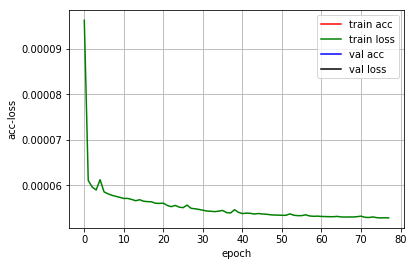

In [150]:
history_tint_0.loss_plot('epoch')

In [99]:
#sgd=keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
#adm=keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
ada=keras.optimizers.Adagrad(lr=0.01, epsilon=1e-06)
history = LossHistory()

def dev_metric(y_true, y_pred):
    return K.mean(K.abs(y_pred-y_true))

autoencoder_tint_0.compile(loss='mse',optimizer=ada, metrics=[dev_metric])
autoencoder_tint_0.fit(train_data_tint_0, train_data_tint_0,
                nb_epoch=10**3,
                batch_size=256,
                shuffle=True,
                callbacks=[history],
                verbose=1)

E:\Anaconda3_5\lib\site-packages\ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Epoch 1/1000
854/854 [==============================] - ETA: 2s - loss: 0.0026 - dev_metric: 0.02 - 1s 1ms/step - loss: 0.0555 - dev_metric: 0.1458
Epoch 2/1000
854/854 [==============================] - ETA: 0s - loss: 0.0185 - dev_metric: 0.08 - 0s 59us/step - loss: 0.0144 - dev_metric: 0.0707
Epoch 3/1000
854/854 [==============================] - ETA: 0s - loss: 0.0080 - dev_metric: 0.04 - 0s 67us/step - loss: 0.0074 - dev_metric: 0.0466
Epoch 4/1000
854/854 [==============================] - ETA: 0s - loss: 0.0089 - dev_metric: 0.05 - 0s 67us/step - loss: 0.0077 - dev_metric: 0.0472
Epoch 5/1000
854/854 [==============================] - ETA: 0s - loss: 0.0055 - dev_metric: 0.03 - 0s 68us/step - loss: 0.0056 - dev_metric: 0.0390
Epoch 6/1000
854/854 [==============================] - ETA: 0s - loss: 0.0055 - dev_metric: 0.03 - 0s 62us/step - loss: 0.0053 - dev_metric: 0.0372
Epoch 7/1000
854/854 [==============================] - ETA: 0s - loss: 0.0046 - dev_metric: 0.03 - 0s 67us

Epoch 56/1000
854/854 [==============================] - ETA: 0s - loss: 0.0027 - dev_metric: 0.02 - 0s 63us/step - loss: 0.0026 - dev_metric: 0.0249
Epoch 57/1000
854/854 [==============================] - ETA: 0s - loss: 0.0027 - dev_metric: 0.02 - 0s 59us/step - loss: 0.0027 - dev_metric: 0.0250
Epoch 58/1000
854/854 [==============================] - ETA: 0s - loss: 0.0027 - dev_metric: 0.02 - 0s 58us/step - loss: 0.0027 - dev_metric: 0.0253
Epoch 59/1000
854/854 [==============================] - ETA: 0s - loss: 0.0028 - dev_metric: 0.02 - 0s 59us/step - loss: 0.0028 - dev_metric: 0.0257
Epoch 60/1000
854/854 [==============================] - ETA: 0s - loss: 0.0029 - dev_metric: 0.02 - 0s 47us/step - loss: 0.0028 - dev_metric: 0.0258
Epoch 61/1000
854/854 [==============================] - ETA: 0s - loss: 0.0028 - dev_metric: 0.02 - 0s 57us/step - loss: 0.0028 - dev_metric: 0.0256
Epoch 62/1000
854/854 [==============================] - ETA: 0s - loss: 0.0027 - dev_metric: 0.02 -

KeyboardInterrupt: 

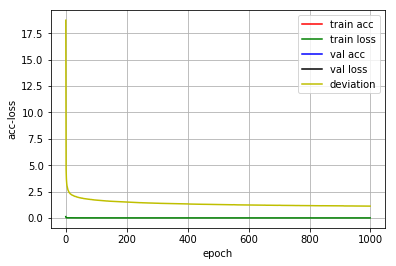

In [76]:
history.loss_plot('epoch')

## ->Load the trained model from my server

In [6]:
# Loading all the models
autoencoder_tint_0=keras.models.load_model('model_0801/autoencoder_withoutstn_tint_0_3layers_200000.h5')
encoder_tint_0=keras.models.load_model('model_0801/encoder_withoutstn_tint_0_3layers_200000.h5')
scaler_tint_0=joblib.load('model_0801/scaler_without_tint_0.asv')

autoencoder_tint_1=keras.models.load_model('model_0801/autoencoder_withoutstn_tint_1_3layers_200000.h5')
encoder_tint_1=keras.models.load_model('model_0801/encoder_withoutstn_tint_1_3layers_200000.h5')
scaler_tint_1=joblib.load('model_0801/scaler_without_tint_1.asv')


autoencoder_tint_2=keras.models.load_model('model_0801/autoencoder_withoutstn_tint_2_3layers_200000.h5')
encoder_tint_2=keras.models.load_model('model_0801/encoder_withoutstn_tint_2_3layers_200000.h5')
scaler_tint_2=joblib.load('model_0801/scaler_without_tint_2.asv')

autoencoder_tint_3=keras.models.load_model('model_0801/autoencoder_withoutstn_tint_3_3layers_200000.h5')
encoder_tint_3=keras.models.load_model('model_0801/encoder_withoutstn_tint_3_3layers_200000.h5')
scaler_tint_3=joblib.load('model_0801/scaler_without_tint_3.asv')

autoencoder_tint_4=keras.models.load_model('model_0801/autoencoder_withoutstn_tint_4_3layers_200000.h5')
encoder_tint_4=keras.models.load_model('model_0801/encoder_withoutstn_tint_4_3layers_200000.h5')
scaler_tint_4=joblib.load('model_0801/scaler_without_tint_4.asv')

autoencoder_tint_5=keras.models.load_model('model_0801/autoencoder_withoutstn_tint_5_3layers_200000.h5')
encoder_tint_5=keras.models.load_model('model_0801/encoder_withoutstn_tint_5_3layers_200000.h5')
scaler_tint_5=joblib.load('model_0801/scaler_without_tint_5_2.asv')

autoencoder_tint_6=keras.models.load_model('model_0801/autoencoder_withoutstn_tint_6_3layers_200000.h5')
encoder_tint_6=keras.models.load_model('model_0801/encoder_withoutstn_tint_6_3layers_200000.h5')
scaler_tint_6=joblib.load('model_0801/scaler_without_tint_6.asv')

flowDict_int=joblib.load('flowMat_dict_tint_stn_onehot.asv')
flowDict_tint=joblib.load('flowMat_dict_tint.asv')

for i in range(7):
    eq0='train_data_tint_'+str(i)+'=flowDict_tint['+str(i)+']'
    eq1='train_data_tint_'+str(i)+'=scaler_tint_'+str(i)+'.transform(train_data_tint_'+str(i)+')'
    exec(eq0)
    exec(eq1)

encoded_tint_6=autoencoder_tint_6.predict(train_data_tint_6)
encoded_tint_5=autoencoder_tint_5.predict(train_data_tint_5)
encoded_tint_4=autoencoder_tint_4.predict(train_data_tint_4)
encoded_tint_3=autoencoder_tint_3.predict(train_data_tint_3)
encoded_tint_2=autoencoder_tint_2.predict(train_data_tint_2)
encoded_tint_1=autoencoder_tint_1.predict(train_data_tint_1)
encoded_tint_0=autoencoder_tint_0.predict(train_data_tint_0)

E:\Anaconda3_5\lib\site-packages\keras\engine\saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
E:\Anaconda3_5\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Text(0,0.5,'Loss: predict - true value')

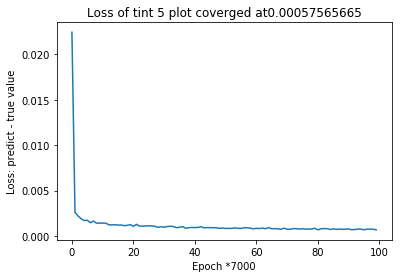

In [52]:
#print(np.min(losses_tint_4['batch']))
plt.plot(losses_tint_4['batch'][0:700000:7000])
plt.title('Loss of tint 5 plot coverged at'+str(np.min(losses_tint_4['batch'])))
plt.xlabel('Epoch *7000')
plt.ylabel('Loss: predict - true value')

### Test the deviation, loss and performance on clustering

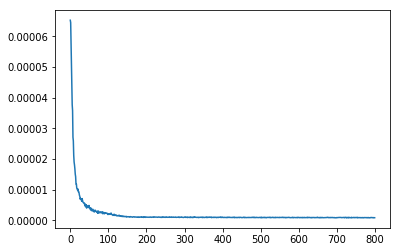

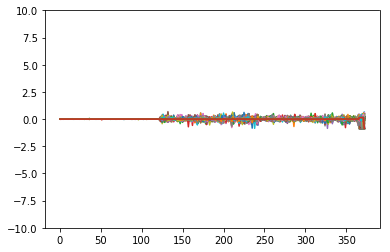

In [125]:
#loss_idx=range(0,len(losses_tint_0['batch']),1000)
loss_toplot=[losses_tint_0['batch'][e] for e in list(loss_idx)]
plt.figure(0)
plt.plot(loss_toplot)
plt.show()

pred_tint_0=autoencoder_tint_0.predict(train_data_tint_0)
dev_tint_0=(pred_tint_0-train_data_tint_0)*norm_tint_0
plt.figure(1)

axes=plt.gca()
for i in range(len(dev_tint_0)):
    plt.plot(dev_tint_0[i])
#plt.ylim=((-10,10))
axes.set_ylim([-10,10])
plt.show()

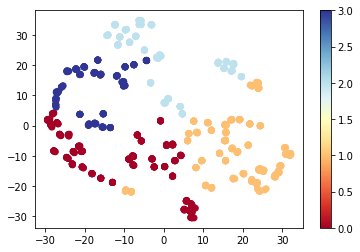

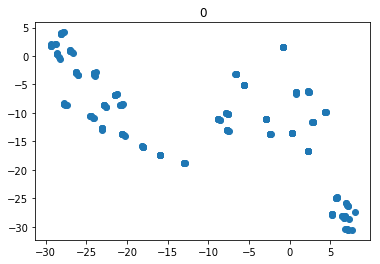

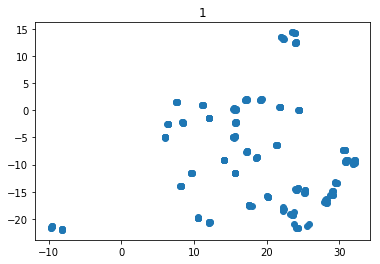

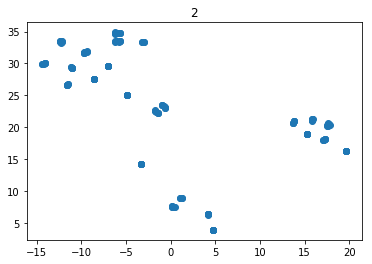

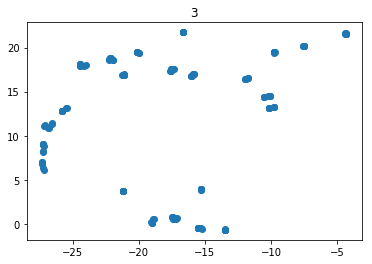

0.25021502
0.31191933
388.52841676360606


In [9]:
encoded_tint_0=encoder_tint_0.predict(train_data_tint_0)
tint_n_clusters=4
tint_linkage='ward'
tint_affinity='euclidean'
agglo=sklearn.cluster.AgglomerativeClustering(n_clusters=tint_n_clusters,linkage=tint_linkage,affinity=tint_affinity)
labels_tint_0=agglo.fit_predict(encoded_tint_0)
tsne_tint_0=TSNE(n_components=2,learning_rate=100).fit_transform(encoded_tint_0)

plt.figure(7)
plt.scatter(tsne_tint_0[:,0],tsne_tint_0[:,1],c=labels_tint_0,cmap=plt.cm.get_cmap('RdYlBu'))
plt.colorbar()
figname='model_0801/tint_0-clusters_'+str(tint_n_clusters)+'-link_'+tint_linkage+'_affin_'+tint_affinity+'.pdf'
plt.savefig(figname)
plt.show()
#f,a=plt.subplots(1,6,figsize=(5,5))
for i in range(tint_n_clusters):
    plt.figure(i)
    lb=labels_tint_0==i
    plt.scatter(tsne_tint_0[lb,0],tsne_tint_0[lb,1])
    plt.title(str(i))
plt.show()
# Silhouette score
print(sklearn.metrics.silhouette_score(encoded_tint_0,labels_tint_0,metric='euclidean'))
print(sklearn.metrics.silhouette_score(encoded_tint_0,labels_tint_0,metric='cosine'))
print(sklearn.metrics.calinski_harabaz_score(encoded_tint_0,labels_tint_0))

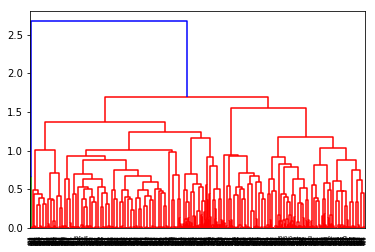

In [82]:
hier_tint_0=scipy.cluster.hierarchy.linkage(encoded_tint_0,method='average')
dn_tint_0=scipy.cluster.hierarchy.dendrogram(hier_tint_0)

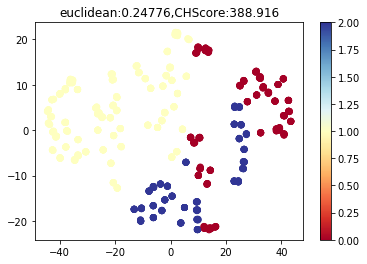

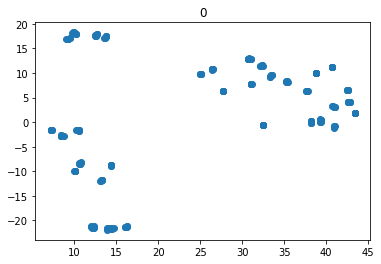

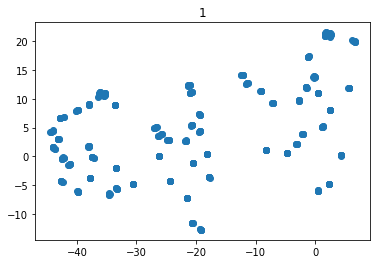

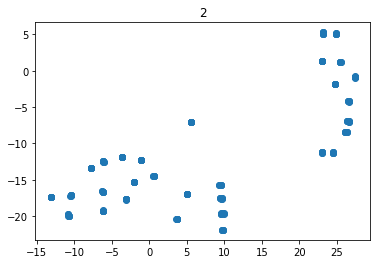

0.04140293
0.24776182
388.91615952857865


In [10]:
encoded_tint_1=encoder_tint_1.predict(train_data_tint_1)
tint_n_clusters=3
tint_linkage='ward'
tint_affinity='euclidean'
agglo=sklearn.cluster.AgglomerativeClustering(n_clusters=tint_n_clusters,linkage=tint_linkage,affinity=tint_affinity)
#hier_tint_1=sklearn.cluster.hierarchicalrchy.linkage(encoded_tint_1,method='')
labels_tint_1=agglo.fit_predict(encoded_tint_1)
tsne_tint_1=TSNE(n_components=2,learning_rate=100).fit_transform(encoded_tint_1)

plt.figure(7)
plt.scatter(tsne_tint_1[:,0],tsne_tint_1[:,1],c=labels_tint_1,cmap=plt.cm.get_cmap('RdYlBu'))
plt.colorbar()
plt.title(tint_affinity+':{:.5f},CHScore:{:.3f}'.format(sklearn.metrics.silhouette_score(encoded_tint_1,labels_tint_1,metric=tint_affinity),
                                                       sklearn.metrics.calinski_harabaz_score(encoded_tint_1,labels_tint_1)))
figname='model_0801/tint_1-clusters_'+str(tint_n_clusters)+'-link_'+tint_linkage+'_affin_'+tint_affinity+'.pdf'
plt.savefig(figname)
plt.show()
#f,a=plt.subplots(1,6,figsize=(5,5))
for i in range(tint_n_clusters):
    plt.figure(i)
    lb=labels_tint_1==i
    plt.scatter(tsne_tint_1[lb,0],tsne_tint_1[lb,1])
    plt.title(str(i))
plt.show()
# Silhouette score
print(sklearn.metrics.silhouette_score(encoded_tint_1,labels_tint_1,metric='cosine'))
print(sklearn.metrics.silhouette_score(encoded_tint_1,labels_tint_1,metric=tint_affinity))
print(sklearn.metrics.calinski_harabaz_score(encoded_tint_1,labels_tint_1))

(854,)
[0.66393411 0.66394389 0.66447967 0.66463661 0.66437668 0.66245121
 0.6624369 ]
(array([ 37, 159, 281, 403, 525, 647, 769], dtype=int64),)
STN Lorong Chuan


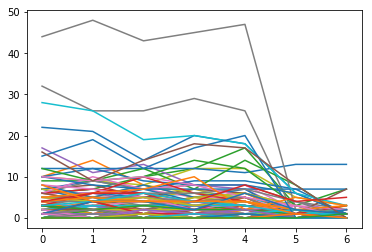

In [41]:
print(np.shape(sim_cos_0_1))
sim_cos_0_1=np.array(sim_cos_0_1)
print(sim_cos_0_1[sim_cos_0_1>0.6])
print(np.where(sim_cos_0_1>0.6))
print(stationDict[37])
plt.plot((train_data_tint_0*norm_tint_0*norm_tint_ori_0)[np.where(sim_cos_0_1>0.6)])

In [43]:
(train_data_tint_0*norm_tint_0*norm_tint_ori_0)[np.where(sim_cos_0_1>0.6)]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

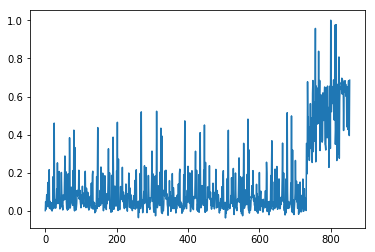

In [95]:
sim_cos_0_1_all=sklearn.metrics.pairwise.cosine_similarity(encoded_tint_4)
plt.plot(sim_cos_0_1_all[800])

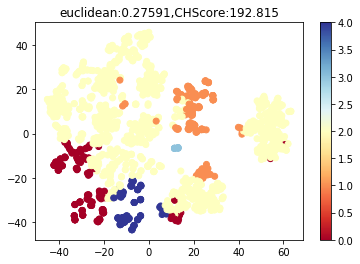

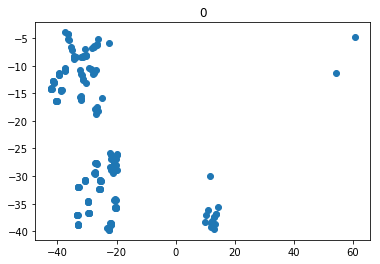

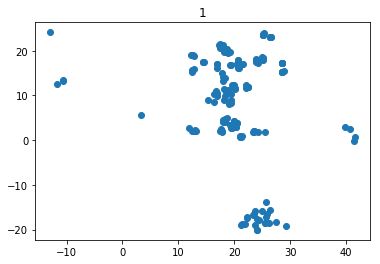

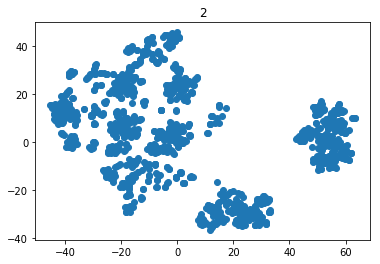

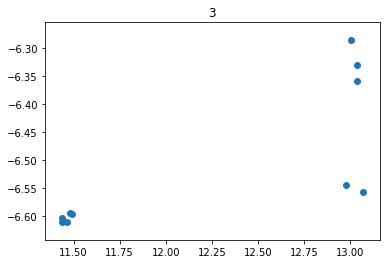

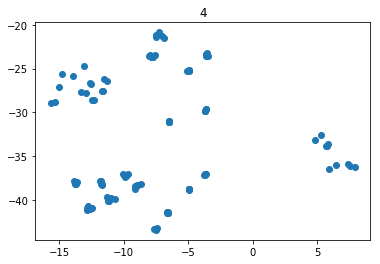

-0.061604045
0.27590883
192.81451248506306


In [10]:
# What about the clustering of these two encoded vectors
tint_n_clusters=5
tint_linkage='ward'
tint_affinity='euclidean'
agglo=sklearn.cluster.AgglomerativeClustering(n_clusters=tint_n_clusters,linkage=tint_linkage,affinity=tint_affinity)
#hier_tint_1=sklearn.cluster.hierarchicalrchy.Olinkage(encoded_tint_1,method='')
encoded_test=np.row_stack((encoded_tint_0,encoded_tint_1))
labels_tint_1=agglo.fit_predict(np.row_stack(encoded_test))
tsne_tint_1=TSNE(n_components=2,learning_rate=100).fit_transform(encoded_test)
#labels_tint_1[854:]+=10

plt.figure(7)
plt.scatter(tsne_tint_1[:,0],tsne_tint_1[:,1],c=labels_tint_1,cmap=plt.cm.get_cmap('RdYlBu'))
plt.colorbar()
plt.title(tint_affinity+':{:.5f},CHScore:{:.3f}'.format(sklearn.metrics.silhouette_score(encoded_test,labels_tint_1,metric=tint_affinity),
                                                       sklearn.metrics.calinski_harabaz_score(encoded_test,labels_tint_1)))
figname='fig/tint_test-clusters_'+str(tint_n_clusters)+'-link_'+tint_linkage+'_affin_'+tint_affinity+'.pdf'
plt.savefig(figname)
plt.show()
#f,a=plt.subplots(1,6,figsize=(5,5))
for i in range(tint_n_clusters):
    plt.figure(i)
    lb=labels_tint_1==i
    plt.scatter(tsne_tint_1[lb,0],tsne_tint_1[lb,1])
    plt.title(str(i))
plt.show()
# Silhouette score
print(sklearn.metrics.silhouette_score(encoded_test,labels_tint_1,metric='cosine'))
print(sklearn.metrics.silhouette_score(encoded_test,labels_tint_1,metric=tint_affinity))
print(sklearn.metrics.calinski_harabaz_score(encoded_test,labels_tint_1))

STN Woodlands
STN Woodlands
STN Woodlands
STN Woodlands
STN Woodlands
STN Woodlands
STN Woodlands


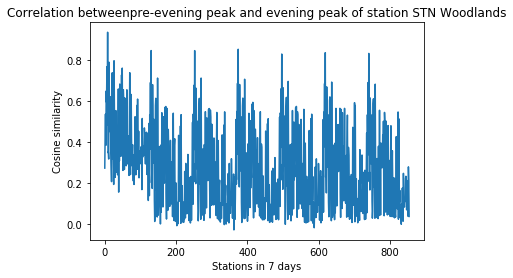

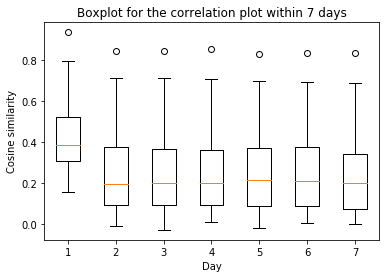

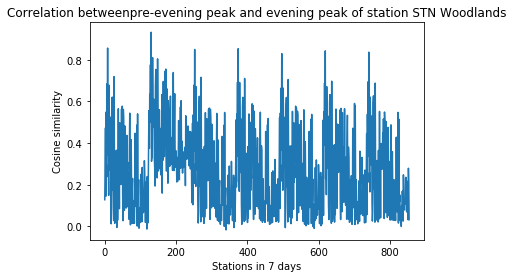

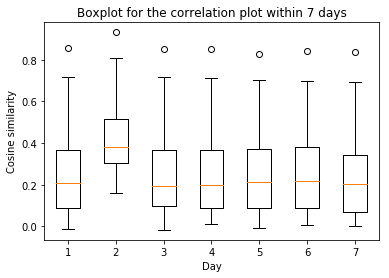

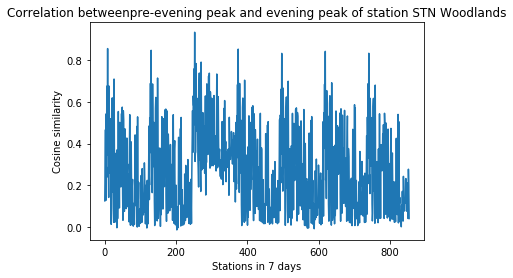

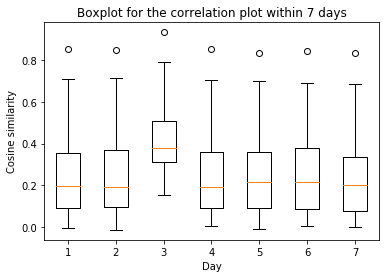

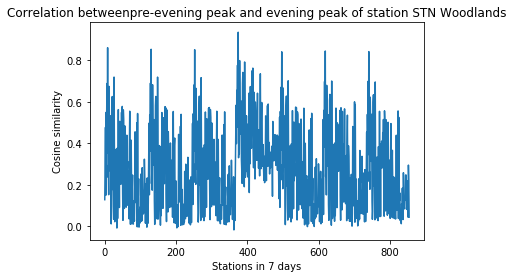

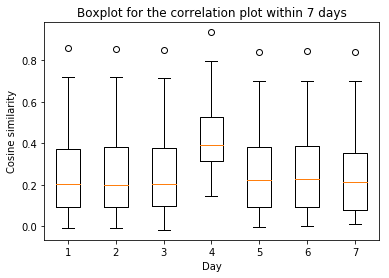

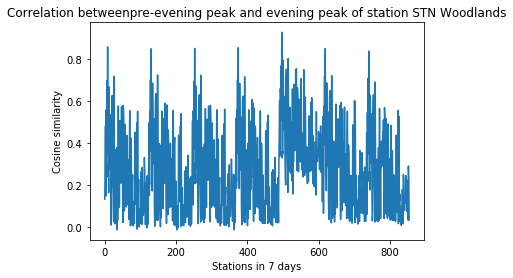

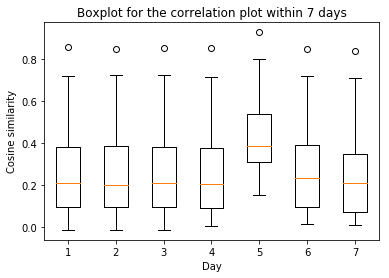

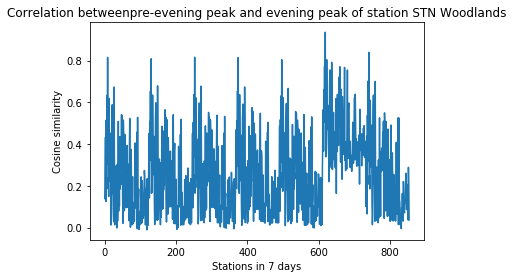

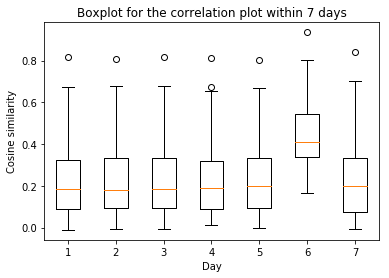

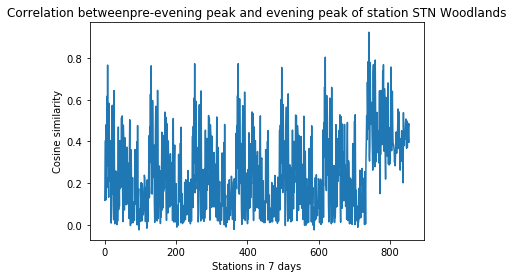

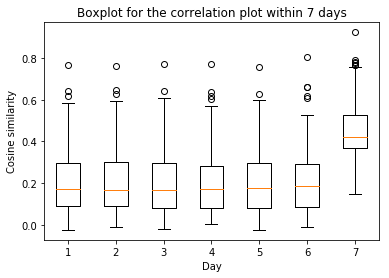

In [48]:
#print(np.shape(sklearn.metrics.pairwise.cosine_similarity(encoded_tint_4)))
#print(stationDict[8])
for i in range(8,854,122):
    t1=sklearn.metrics.pairwise.cosine_similarity(encoded_tint_4,encoded_tint_3)[i]
    plt.figure(i)
    plt.plot(t1)
    plt.title('Correlation between'+tint_dict[3]+' and '+tint_dict[4]+' of station '+stationDict[int(i%122)])
    #plt.title('Correlation within the tint: '+tint_dict[4])
    plt.xlabel('Stations in 7 days')
    plt.ylabel('Cosine similarity')
    plt.figure(i+1)
    plt.boxplot([ t1[e*122:(e+1)*122] for e in range(7)])
    plt.title('Boxplot for the correlation plot within 7 days')
    plt.xlabel('Day')
    plt.ylabel('Cosine similarity')
    #print(getStationNames(np.where(t1>0.95)[0]))
    print(stationDict[int(i%122)])

STN Kranji
(['STN Kranji'], ['STN Kranji'], [['NS']])


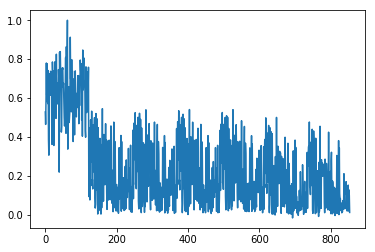

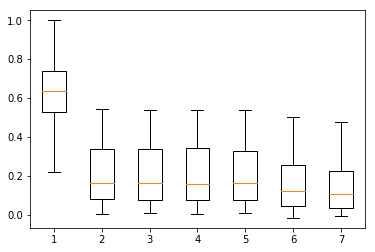

In [76]:
print(stationDict[62])
t1=sklearn.metrics.pairwise.cosine_similarity(encoded_tint_4)[62]
plt.figure(0)
plt.plot(t1)
plt.figure(1)
plt.boxplot([ t1[e*122:(e+1)*122] for e in range(7)])
print(getStationNames(np.where(t1>0.95)[0]))

STN Admiralty
(['STN Sembawang', 'STN Admiralty', 'STN Woodlands', 'STN Kranji'], ['STN Woodlands', 'STN Admiralty', 'STN Sembawang', 'STN Woodlands', 'STN Admiralty', 'STN Woodlands', 'STN Admiralty', 'STN Woodlands', 'STN Admiralty', 'STN Woodlands', 'STN Admiralty', 'STN Kranji', 'STN Admiralty', 'STN Admiralty'])


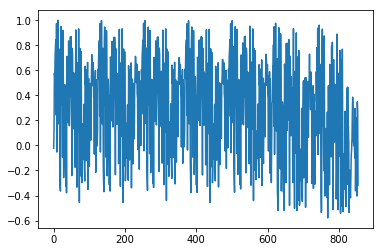

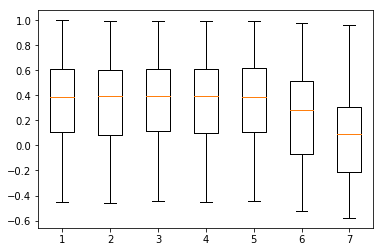

In [127]:
print(stationDict[12])
t1=sklearn.metrics.pairwise.cosine_similarity(encoded_tint_4)[12]
plt.figure(0)
plt.plot(t1)
plt.figure(1)
plt.boxplot([ t1[e*122:(e+1)*122] for e in range(7)])
print(getStationNames(np.where(t1>0.95)[0]))


For tint morning peak
Abnormal stations (absolute deviation >10) ['STN City Hall', 'STN Woodlands', 'STN Bedok', 'STN Pioneer', 'STN Serangoon', 'STN Bugis', 'STN Tanjong Pagar', 'STN Pasir Ris', 'STN Tampines', 'STN Raffles Place', 'STN Jurong East', 'STN Toa Payoh', 'STN Clementi', 'STN Bishan', 'STN Sembawang', 'STN Yew Tee', 'STN Orchard', 'STN Choa Chu Kang', 'STN Ang Mo Kio', 'STN Expo', 'STN Admiralty', 'STN Boon Lay', 'STN Yishun', 'STN Novena']
Abnormal stations (absolute deviation >20) ['STN Tanjong Pagar', 'STN Raffles Place']

For tint morning off-peak
Abnormal stations (absolute deviation >10) ['STN Chinatown', 'STN City Hall', 'STN Woodlands', 'STN Bedok', 'STN Pioneer', 'STN Serangoon', 'STN Aljunied', 'STN Bugis', 'STN Tanjong Pagar', 'STN Pasir Ris', 'STN Tampines', 'STN Raffles Place', 'STN Jurong East', 'STN Toa Payoh', 'STN Clementi', 'STN Somerset', 'STN Bishan', 'STN Sembawang', 'STN Yew Tee', 'STN Orchard', 'STN Dhoby Ghaut', 'STN Choa Chu Kang', 'STN Ang Mo Kio

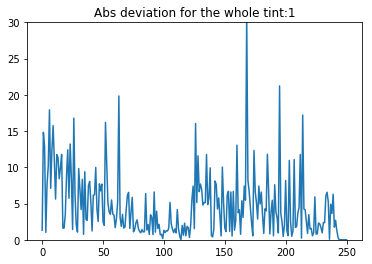

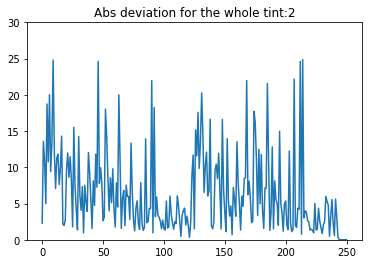

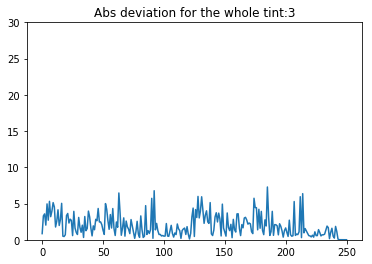

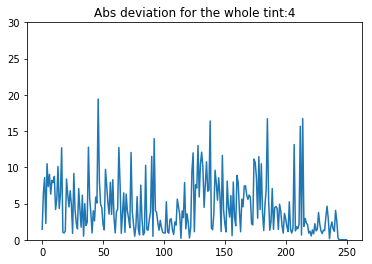

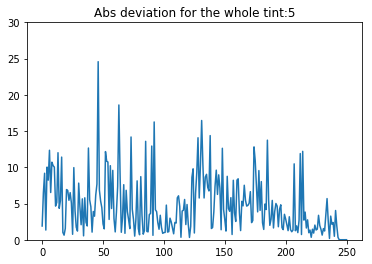

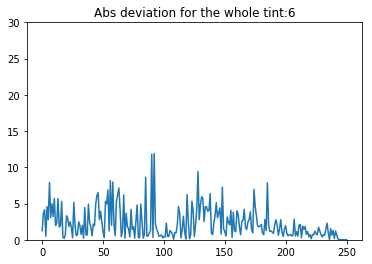

In [131]:
# Plot the absolute deviation and list all the abnormal stations
for i in range(1,7):
    print('\nFor tint '+tint_dict[i])
    eq1='pred_tint=autoencoder_tint_'+str(i)+'.predict(train_data_tint_'+str(i)+')'
    eq2='dev_tint=scaler_tint_'+str(i)+'.inverse_transform(pred_tint-train_data_tint_'+str(i)+')'
    exec(eq1)
    exec(eq2)
    plt.figure(i)
    axes=plt.gca()
    plt.plot(np.mean(np.abs(dev_tint),axis=0))
    plt.title('Abs deviation for the whole tint:'+str(i))
    axes.set_ylim([0,30])
    s,_,_=getStationNames(np.where(np.mean(np.abs(dev_tint),axis=0)>10)[0])
    print('Abnormal stations (absolute deviation >10)',s)
    s,_,_=getStationNames(np.where(np.mean(np.abs(dev_tint),axis=0)>20)[0])
    print('Abnormal stations (absolute deviation >20)',s)

In [62]:
np.sum(flowDict_tint[1][stationDict_re[ 'STN Raffles Place']])

48087.0

Average real deviation of tint 5 in 7 days:  4.709169582488782
Average real deviation/std of tint 5 in 7 days:  0.06545891338328326
Outliers (deviation/std>0.05) in 854*251 elements:  310 Portion:  0.0014462058090821725
Outliers (real deviation>10) in 854*251 elements: 27209 Portion:  0.12693488341715106


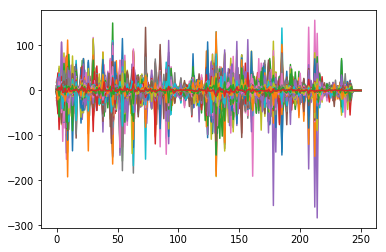

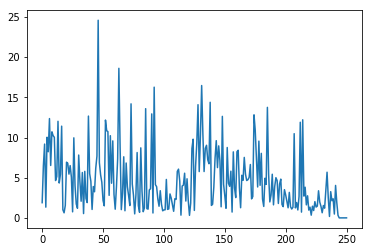

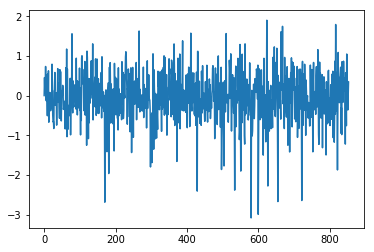

In [56]:
# What if I plot the deviation dived by standard-deviation respectively?
# Until 2018/8/4 tint 0-4 are still 373 while 5&6 are 251 dimensions
'''pred_tint_1=autoencoder_tint_1.predict(train_data_tint_1)
dev_tint_1=(pred_tint_1-train_data_tint_1)*norm_tint_ori_1
plt.figure(1)
for i in range(len(dev_tint_1)):
    plt.plot(dev_tint_1[i])'''
# Because the plot has merged 854 sets of data, it would not be surprising that there are many large outliers
pred_tint_5=autoencoder_tint_5.predict(train_data_tint_5)
print('Average real deviation of tint 5 in 7 days: ',np.mean(np.abs(scaler_tint_5.inverse_transform(pred_tint_5-train_data_tint_5))))
print('Average real deviation/std of tint 5 in 7 days: ',np.mean(np.abs(scaler_tint_5.inverse_transform(pred_tint_5-train_data_tint_5))/np.std(flowDict_tint[5])))
print('Outliers (deviation/std>0.05) in 854*251 elements: ',np.sum((np.abs(scaler_tint_5.inverse_transform(pred_tint_5-train_data_tint_5))//np.std(flowDict_tint[5]))>0.05),'Portion: ',np.sum((np.abs(scaler_tint_5.inverse_transform(pred_tint_5-train_data_tint_5))//np.std(flowDict_tint[5]))>0.05)/(854*251))
print('Outliers (real deviation>10) in 854*251 elements:',np.sum(np.abs(scaler_tint_5.inverse_transform(pred_tint_5-train_data_tint_5))>10),'Portion: ',np.sum(np.abs(scaler_tint_5.inverse_transform(pred_tint_5-train_data_tint_5))>10)/(854*251))

pred_tint_5=autoencoder_tint_5.predict(train_data_tint_5)
dev_tint_5=scaler_tint_5.inverse_transform(pred_tint_5-train_data_tint_5)
plt.figure(1)
for i in range(len(dev_tint_5)):
    plt.plot(dev_tint_5[i])
plt.figure(2)
axes=plt.gca()
plt.plot(np.mean(np.abs(dev_tint_5),axis=0))
#axes.set_ylim([-0.5,0.5])
plt.figure(3)
axes=plt.gca()
plt.plot(np.mean(dev_tint_5,axis=1))
#axes.set_ylim([-0.1,0.1])

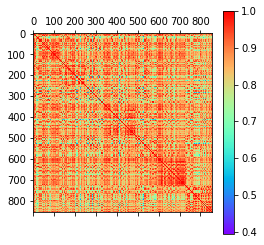

In [71]:
encoded_tint_5=encoder_tint_5.predict(train_data_tint_5)
a=sklearn.metrics.pairwise.cosine_similarity(encoded_tint_5)
plt.figure(figsize=(100,100))
plt.matshow(a,cmap='rainbow')
plt.colorbar()
plt.savefig('fig/tint_5_self_cos_20180804.pdf')
plt.show()

In [ ]:
np.savetxt('tint_0_cos.csv',a,delimiter=',')

## Analyze the similarity of stations in spatial features and service features. Then discuss the similarity or difference of their flow features

In [1]:
# FACK PYTHON VERSIONS
import sys
# 1
import pandas.core.indexes 
sys.modules['pandas.indexes'] = pandas.core.indexes
# 2
import pandas.core.base, pandas.core.indexes.frozen
setattr(sys.modules['pandas.core.base'],'FrozenNDArray', pandas.core.indexes.frozen.FrozenNDArray)

In [158]:
# Change into time-interval based dataFrame
'''
stationFeat_0319=joblib.load('stationFeatDF_0319.asv')
stationFeat_0320=joblib.load('stationFeatDF_0320.asv')
stationFeat_0321=joblib.load('stationFeatDF_0321.asv')
stationFeat_0322=joblib.load('stationFeatDF_0322.asv')
stationFeat_0323=joblib.load('stationFeatDF_0323.asv')
stationFeat_0324=joblib.load('stationFeatDF_0324.asv')
stationFeat_0325=joblib.load('stationFeatDF_0325.asv')

columns_selected=['total_flow','adu_dis','chd_dis','sen_dis','ori_dist','des_dist','ori_runtime','des_runtime']

for tint in range(7):
    eq0='stationFeat_tint_'+str(tint)+'=pd.DataFrame(columns=columns_selected)' # The feature is 244+7 adding 122 dimension one-hot for station identification
    exec(eq0)

del tint,eq0

cnt=0
for day in ['0319','0320','0321','0322','0323','0324','0325']:
    columns_selected=['total_flow','adu_dis','chd_dis','sen_dis','ori_dist','des_dist','ori_runtime','des_runtime']
    eq1='tmp=stationFeat_'+day+ '[columns_selected]'
    exec(eq1)
    
    # flowMat has 122*7 rows, from Monday to Sunday
    stationFeat_tint_0=stationFeat_tint_0.append(tmp.loc[0:(122-1),columns_selected],ignore_index=True)
    stationFeat_tint_1=stationFeat_tint_1.append(tmp.loc[122:(122*2-1),columns_selected],ignore_index=True)
    stationFeat_tint_2=stationFeat_tint_2.append(tmp.loc[(122*2):(122*3-1),columns_selected],ignore_index=True)
    stationFeat_tint_3=stationFeat_tint_3.append(tmp.loc[(122*3):(122*4-1),columns_selected],ignore_index=True)
    stationFeat_tint_4=stationFeat_tint_4.append(tmp.loc[(122*4):(122*5-1),columns_selected],ignore_index=True)
    stationFeat_tint_5=stationFeat_tint_5.append(tmp.loc[(122*5):(122*6-1),columns_selected],ignore_index=True)
    stationFeat_tint_6=stationFeat_tint_6.append(tmp.loc[(122*6):(122*7-1),columns_selected],ignore_index=True)    
    cnt+=1
del cnt
stationFeat_tint={}
for i in range(7):
    eq3='stationFeat_tint['+str(i)+']=stationFeat_tint_'+str(i)
    exec(eq3)
joblib.dump(stationFeat_tint,'stationFeat_tint_dict.asv')
'''

['stationFeat_tint_dict.asv']

### ->Load POI spatial and analysis data

In [136]:
# Load POI and spatial data
stationFeat_tint_dict=joblib.load('stationFeat_tint_dict.asv')
poi_tf_idf=joblib.load('poi_tf_idf.asv')
station_POI_Intsec=pd.read_csv('MRTStops_Geo_POI_Interchange_Lines_Handmade_NewPOI.csv')
columns_selected=['total_flow','adu_dis','chd_dis','sen_dis','ori_dist','des_dist','ori_runtime','des_runtime']
#'establishment','food','store','restaurant'
poi_selected=[ 'finance', 'bus_station', 'transit_station', 'place_of_worship', 'health',
       'supermarket', 'shopping_mall',  'school', 'parking', 'park',
       'political', 'storage', 'intsec','lodging','hospital','car_rental',
        'car_dealer','car_repair','bar','cafe','local_government_office','bicycle_store']
    
poi_mat=np.mat(station_POI_Intsec.loc[:,poi_selected])
spa_mat=np.zeros((0,len(columns_selected)))
for i in range(7):
    spa_mat=np.row_stack((spa_mat,stationFeat_tint_dict[i]))
spa_mat_meta=joblib.load('spa_mat_meta.asv')

### For POI clustering

E:\Anaconda3_5\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


13
1


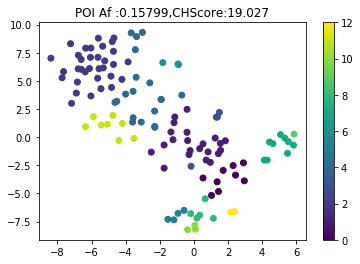

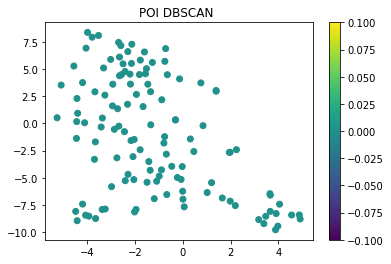

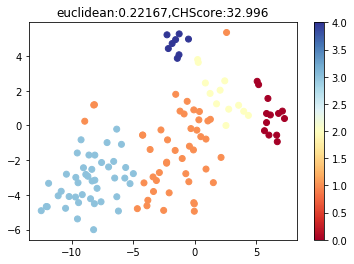

In [8]:
# Use different kinds of clutering 
# Affinity propagation
scaler_poi=sklearn.preprocessing.MinMaxScaler()
scaler_poi.fit(poi_mat)
poi_mat_norm=scaler_poi.transform(poi_mat)
af=sklearn.cluster.AffinityPropagation()
poi_labels=af.fit_predict(poi_mat_norm)
print(len(list(set(poi_labels))))
poi_tsne=TSNE(n_components=2,learning_rate=200).fit_transform(poi_mat_norm)
plt.figure(0)
plt.scatter(poi_tsne[:,0],poi_tsne[:,1],c=poi_labels)
plt.title('POI Af :{:.5f},CHScore:{:.3f}'.format(sklearn.metrics.silhouette_score(poi_mat_norm,poi_labels),
                                                       sklearn.metrics.calinski_harabaz_score(poi_mat_norm,poi_labels)))
plt.colorbar()
plt.savefig('fig/poi_new_af_default.pdf')
# DBSCAN
db=sklearn.cluster.DBSCAN(metric='cosine',min_samples=1)
poi_labels_db=db.fit_predict(poi_mat_norm)
print(len(list(set(poi_labels_db))))
poi_tsne=TSNE(n_components=2,learning_rate=200).fit_transform(poi_mat_norm)
plt.figure(1)
plt.scatter(poi_tsne[:,0],poi_tsne[:,1],c=poi_labels_db)
plt.title('POI DBSCAN ')
plt.colorbar()
plt.savefig('fig/poi_new_dbscan_cosine_min5.pdf')
# AgglomerativeClustering
tint_n_clusters=5
tint_linkage='ward'
tint_affinity='euclidean'
agglo=sklearn.cluster.AgglomerativeClustering(n_clusters=tint_n_clusters,linkage=tint_linkage,affinity=tint_affinity)
poi_labels_agg=agglo.fit_predict(np.row_stack(poi_mat_norm))
tsne_tint_1=TSNE(n_components=2,learning_rate=100).fit_transform(poi_mat_norm)

plt.figure(2)
plt.scatter(tsne_tint_1[:,0],tsne_tint_1[:,1],c=poi_labels_agg,cmap=plt.cm.get_cmap('RdYlBu'))
plt.colorbar()
plt.title(tint_affinity+':{:.5f},CHScore:{:.3f}'.format(sklearn.metrics.silhouette_score(poi_mat_norm,poi_labels_agg,metric=tint_affinity),
                                                       sklearn.metrics.calinski_harabaz_score(poi_mat_norm,poi_labels_agg)))
figname='fig/poi_new_agg_clusters_'+str(tint_n_clusters)+'-link_'+tint_linkage+'_affin_'+tint_affinity+'.pdf'
plt.savefig(figname)
plt.show()

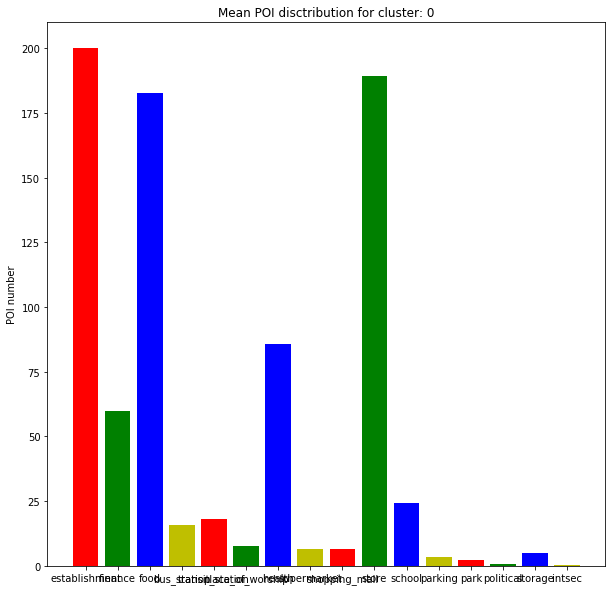

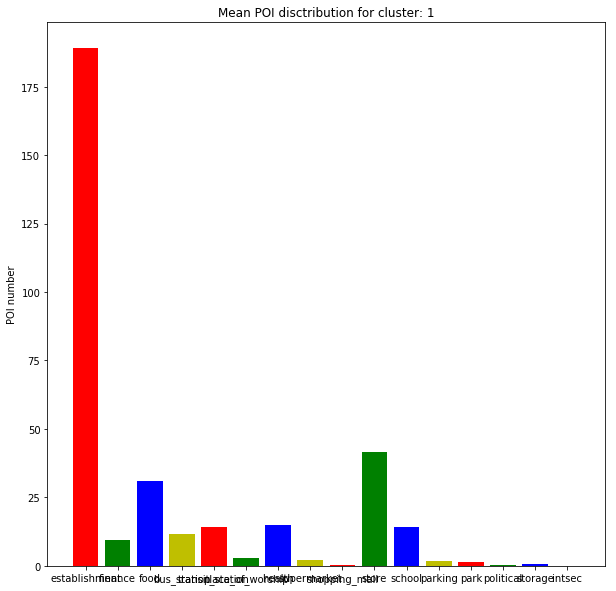

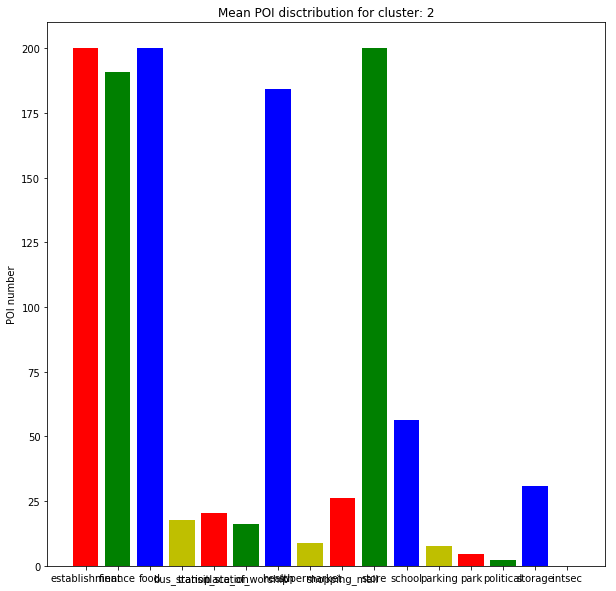

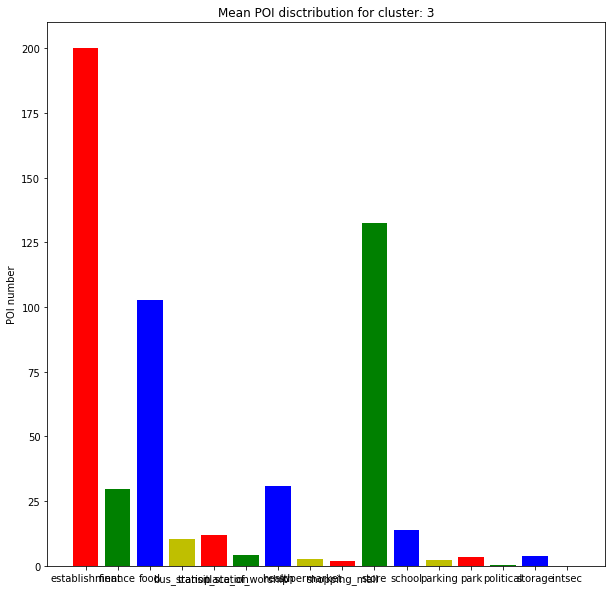

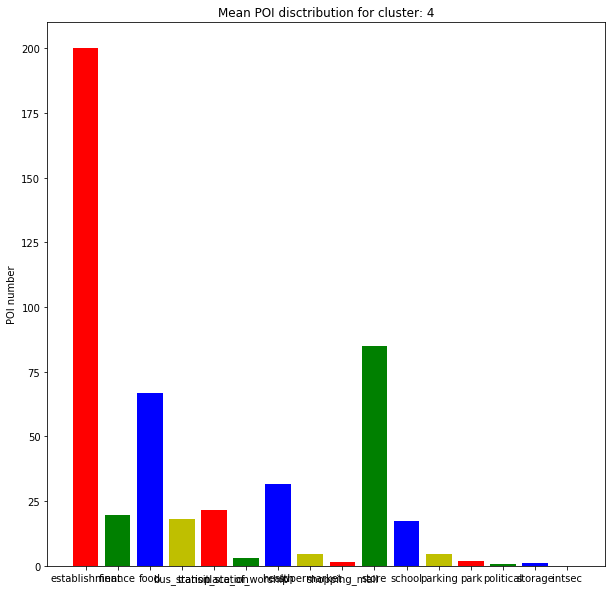

In [50]:
# What is the POI attributes of the generated clusters?
for i in range(tint_n_clusters):
    plt.figure(figsize=(10,10))
    c=np.mean(station_POI_Intsec[poi_selected][poi_labels_agg==i])
    plt.bar(range(len(c)),c, color='rgby')
    plt.xticks(list(range(len(c))),c.keys())
    plt.ylabel('POI number')
    plt.title('Mean POI disctribution for cluster: '+str(i))

#### Compare flow similarity and POI similarity

In [85]:
# Take AgglomerativeClustering as an case to futher discuss their flow similarity
t1=sklearn.metrics.pairwise.cosine_similarity(encoded_tint_5)
# Reduce the efferct of the diag elements
t1=t1+np.diag(-np.diag(t1))
stn_res=[]
for i in range(tint_n_clusters):
    idx_agg=poi_labels_agg==i
    for j in range(6):
        idx_agg=np.append(idx_agg,poi_labels_agg==i)
    a=np.where((t1>0.95)&(idx_agg)&(idx_agg.reshape(-1,1)))
    b=np.append(a[0],a[1])
    unique_b,_=getStationNames(np.unique(b))
    stn_res+=unique_b
    print(i,len(np.unique(unique_b)),'unique stations of mutal similarity \n',np.unique(unique_b))
    
# What about finding the pairs of stations that have mutual similarity instead of an overall output?
'''
print('Find the mutually similar pairs')
stn_res_sep=[]
print('\n')
for i in range(tint_n_clusters):
    idx_agg=poi_labels_agg==i
    for j in range(6):
        idx_agg=np.append(idx_agg,poi_labels_agg==i)
    idx_agg_where=np.where(idx_agg)
    idx_agg_where=idx_agg_where[0]
    for k in range(len(idx_agg_where)-1):
        for kk in range(k+1,len(idx_agg_where)):
            if t1[idx_agg_where[k],idx_agg_where[kk]]>0.95:
                a,_=getStationNames([idx_agg_where[k],idx_agg_where[kk]])
                if len(a)>1:
                    stn_res_sep.append(a)
                    print('Mutually similar pairs (separately):',a,'day:',int(idx_agg_where[k]/122),' ',int(idx_agg_where[kk]/122))
                    
'''

print('Find the different pairs')
stn_res_sep=[]
print('\n')
for i in range(tint_n_clusters):
    idx_agg=poi_labels_agg==i
    for j in range(6):
        idx_agg=np.append(idx_agg,poi_labels_agg==i)
    idx_agg_where=np.where(idx_agg)
    idx_agg_where=idx_agg_where[0]
    for k in range(len(idx_agg_where)-1):
        for kk in range(k+1,len(idx_agg_where)):
            if t1[idx_agg_where[k],idx_agg_where[kk]]<-0.02:
                a,_=getStationNames([idx_agg_where[k],idx_agg_where[kk]])
                if len(a)>1:
                    stn_res_sep.append(a)
                    print('Different pairs (separately):',a,'day:',int(idx_agg_where[k]/122),' ',int(idx_agg_where[kk]/122))

0 21 unique stations of mutal similarity 
 ['STN Ang Mo Kio' 'STN Bakau' 'STN Boon Keng' 'STN Boon Lay'
 'STN Bras Basah' 'STN Bukit Panjang' 'STN Changi Airport' 'STN Chinatown'
 'STN Choa Chu Kang' 'STN Clarke Quay' 'STN Farrer Park' 'STN Hougang'
 'STN Kangkar' 'STN Kovan' 'STN Lavender' 'STN Little India' 'STN Pending'
 'STN Sengkang' 'STN Serangoon' 'STN Tai Seng' 'STN Yishun']
1 21 unique stations of mutal similarity 
 ['STN Bartley' 'STN Caldecott' 'STN Chinese Garden' 'STN Compassvale'
 'STN Haw Par Villa' 'STN Joo Koon' 'STN Kadaloor' 'STN Keat Hong'
 'STN Kent Ridge' 'STN Lorong Chuan' 'STN Marymount' 'STN Oasis'
 'STN Orchard' 'STN Phoenix' 'STN Rumbia' 'STN Senja' 'STN Tampines'
 'STN Teck Whye' 'STN Thanggam' 'STN Tongkang' 'STN one-north']
2 5 unique stations of mutal similarity 
 ['STN Esplanade' 'STN Promenade' 'STN Raffles Place' 'STN Renjong'
 'STN Riviera']
3 7 unique stations of mutal similarity 
 ['STN Botanic Gardens' 'STN Farmway' 'STN Farrer Road' 'STN Layar'
 '

#### POI vs Flow between different days

In [26]:
# What about the infomation between different work days?
print('tint pairs: ',tint_dict[3],' and ',tint_dict[2])
t2=sklearn.metrics.pairwise.cosine_similarity(encoded_tint_3,encoded_tint_2)
t2=t2+np.diag(-np.diag(t2))
stn_res=[]
for i in range(tint_n_clusters):
    idx_agg=poi_labels_agg==i
    for j in range(6):
        idx_agg=np.append(idx_agg,poi_labels_agg==i)
    a=np.where((t2>0.95)&(idx_agg)&(idx_agg.reshape(-1,1)))
    b=np.append(a[0],a[1])
    unique_b,_,_=getStationNames(np.unique(b))
    stn_res+=unique_b
    print(i,len(np.unique(unique_b)),'unique stations of mutal similarity \n',np.unique(unique_b))
    
'''
print('Find the mutually similar pairs')
stn_res_sep=[]
print('\n')
for i in range(tint_n_clusters):
    idx_agg=poi_labels_agg==i
    for j in range(6):
        idx_agg=np.append(idx_agg,poi_labels_agg==i)
    idx_agg_where=np.where(idx_agg)
    idx_agg_where=idx_agg_where[0]
    for k in range(len(idx_agg_where)-1):
        for kk in range(k+1,len(idx_agg_where)):
            if t1[idx_agg_where[k],idx_agg_where[kk]]>0.95:
                a,_=getStationNames([idx_agg_where[k],idx_agg_where[kk]])
                if len(a)>1:
                    stn_res_sep.append(a)
                    print('Mutually similar pairs (separately):',a,'day:',int(idx_agg_where[k]/122),' ',int(idx_agg_where[kk]/122))
                    
'''

print('Find the different pairs')
stn_res_sep=[]
print('\n')
for i in range(tint_n_clusters):
    idx_agg=poi_labels_agg==i
    for j in range(6):
        idx_agg=np.append(idx_agg,poi_labels_agg==i)
    idx_agg_where=np.where(idx_agg)
    idx_agg_where=idx_agg_where[0]
    for k in range(len(idx_agg_where)-1):
        for kk in range(k+1,len(idx_agg_where)):
            if t2[idx_agg_where[k],idx_agg_where[kk]]>0.95:
                a,_,_=getStationNames([idx_agg_where[k],idx_agg_where[kk]])
                if len(a)>1:
                    stn_res_sep.append(a)
                    print('Different pairs (separately):',a,'day:',int(idx_agg_where[k]/122),' ',int(idx_agg_where[kk]/122))
#print(Counter((tuple(i) for i in stn_res_sep)).most_common(5))
print('Different pairs to consider similarity')
t=Counter((tuple(i) for i in stn_res_sep)).most_common(5)
for i in range(len(t)):
    print(t[i][0],'Lines:',getStationLineNames(stationDict_re[t[i][0][0]]),getStationLineNames(stationDict_re[t[i][0][1]]))

tint pairs:  pre-evening peak  and  morning off-peak
0 2 unique stations of mutal similarity 
 ['STN Bakau' 'STN Kangkar']
1 13 unique stations of mutal similarity 
 ['STN Bartley' 'STN Caldecott' 'STN Haw Par Villa' 'STN Joo Koon'
 'STN Kadaloor' 'STN Keat Hong' 'STN Lorong Chuan' 'STN Marymount'
 'STN Oasis' 'STN Teck Whye' 'STN Thanggam' 'STN Tongkang' 'STN one-north']
2 3 unique stations of mutal similarity 
 ['STN Marina Bay' 'STN Renjong' 'STN Riviera']
3 6 unique stations of mutal similarity 
 ['STN Farmway' 'STN Farrer Road' 'STN Layar' 'STN Nicoll Highway'
 'STN Pasir Panjang' 'STN Ranggung']
4 5 unique stations of mutal similarity 
 ['STN Cove' 'STN Damai' 'STN Labrador Park' 'STN Telok Blangah'
 'STN Woodleigh']
Find the different pairs


Different pairs (separately): ['STN Keat Hong', 'STN Teck Whye'] day: 0   0
Different pairs (separately): ['STN Haw Par Villa', 'STN one-north'] day: 0   0
Different pairs (separately): ['STN Haw Par Villa', 'STN Caldecott'] day: 0   0
Diff

In [28]:
# What about the infomation between different work days?
print('tint pairs: ',tint_dict[3],' and ',tint_dict[4])
t2=sklearn.metrics.pairwise.cosine_similarity(encoded_tint_3,encoded_tint_4)
t2=t2+np.diag(-np.diag(t2))
stn_res=[]
for i in range(tint_n_clusters):
    idx_agg=poi_labels_agg==i
    for j in range(6):
        idx_agg=np.append(idx_agg,poi_labels_agg==i)
    a=np.where((t2>0.95)&(idx_agg)&(idx_agg.reshape(-1,1)))
    b=np.append(a[0],a[1])
    unique_b,_,_=getStationNames(np.unique(b))
    stn_res+=unique_b
    print(i,len(np.unique(unique_b)),'unique stations of mutal similarity \n',np.unique(unique_b))
    
'''
print('Find the mutually similar pairs')
stn_res_sep=[]
print('\n')
for i in range(tint_n_clusters):
    idx_agg=poi_labels_agg==i
    for j in range(6):
        idx_agg=np.append(idx_agg,poi_labels_agg==i)
    idx_agg_where=np.where(idx_agg)
    idx_agg_where=idx_agg_where[0]
    for k in range(len(idx_agg_where)-1):
        for kk in range(k+1,len(idx_agg_where)):
            if t1[idx_agg_where[k],idx_agg_where[kk]]>0.95:
                a,_=getStationNames([idx_agg_where[k],idx_agg_where[kk]])
                if len(a)>1:
                    stn_res_sep.append(a)
                    print('Mutually similar pairs (separately):',a,'day:',int(idx_agg_where[k]/122),' ',int(idx_agg_where[kk]/122))
                    
'''

print('Find the different pairs')
stn_res_sep=[]
print('\n')
for i in range(tint_n_clusters):
    idx_agg=poi_labels_agg==i
    for j in range(6):
        idx_agg=np.append(idx_agg,poi_labels_agg==i)
    idx_agg_where=np.where(idx_agg)
    idx_agg_where=idx_agg_where[0]
    for k in range(len(idx_agg_where)-1):
        for kk in range(k+1,len(idx_agg_where)):
            if t2[idx_agg_where[k],idx_agg_where[kk]]>0.95:
                a,_,_=getStationNames([idx_agg_where[k],idx_agg_where[kk]])
                if len(a)>1:
                    stn_res_sep.append(a)
                    print('Different pairs (separately):',a,'day:',int(idx_agg_where[k]/122),' ',int(idx_agg_where[kk]/122))
#print(Counter((tuple(i) for i in stn_res_sep)).most_common(5))
print('Different pairs to consider similarity')
t=Counter((tuple(i) for i in stn_res_sep)).most_common(5)
for i in range(len(t)):
    print(t[i][0],'Lines:',getStationLineNames(stationDict_re[t[i][0][0]]),getStationLineNames(stationDict_re[t[i][0][1]]))

tint pairs:  pre-evening peak  and  evening peak
0 2 unique stations of same POI cluster but different flow info 
 ['STN Bakau' 'STN Kangkar']
1 15 unique stations of same POI cluster but different flow info 
 ['STN Bartley' 'STN Caldecott' 'STN Compassvale' 'STN Haw Par Villa'
 'STN Kadaloor' 'STN Keat Hong' 'STN Kent Ridge' 'STN Lorong Chuan'
 'STN Marymount' 'STN Oasis' 'STN Rumbia' 'STN Teck Whye' 'STN Thanggam'
 'STN Tongkang' 'STN one-north']
2 5 unique stations of same POI cluster but different flow info 
 ['STN Bangkit' 'STN Marina Bay' 'STN Renjong' 'STN Riviera' 'STN Segar']
3 8 unique stations of same POI cluster but different flow info 
 ['STN Botanic Gardens' 'STN Farmway' 'STN Farrer Road' 'STN Fernvale'
 'STN Layar' 'STN Nicoll Highway' 'STN Pasir Panjang' 'STN Ranggung']
4 7 unique stations of same POI cluster but different flow info 
 ['STN Dakota' 'STN Jelapang' 'STN Labrador Park' 'STN Mountbatten'
 'STN South VIEW' 'STN Telok Blangah' 'STN Woodleigh']
Find the diffe

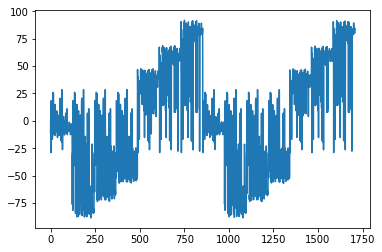

In [123]:
plt.plot(TSNE(n_components=1,learning_rate=100).fit_transform(np.row_stack((encoded_tint_2,encoded_tint_3))))

In [38]:
# What about the infomation between different work days?
t3=sklearn.metrics.pairwise.cosine_similarity(encoded_tint_2,encoded_tint_3)
t3=t3+np.diag(-np.diag(t3))
stn_res=[]
for i in range(tint_n_clusters):
    idx_agg=poi_labels_agg==i
    for j in range(6):
        idx_agg=np.append(idx_agg,poi_labels_agg==i)
    a=np.where((t3>0.95)&(idx_agg)&(idx_agg.reshape(-1,1)))
    b=np.append(a[0],a[1])
    unique_b,_,_=getStationNames(np.unique(b))
    stn_res+=unique_b
    print(i,len(np.unique(unique_b)),'unique stations of mutal similarity \n',np.unique(unique_b))
    
'''
print('Find the mutually similar pairs')
stn_res_sep=[]
print('\n')
for i in range(tint_n_clusters):
    idx_agg=poi_labels_agg==i
    for j in range(6):
        idx_agg=np.append(idx_agg,poi_labels_agg==i)
    idx_agg_where=np.where(idx_agg)
    idx_agg_where=idx_agg_where[0]
    for k in range(len(idx_agg_where)-1):
        for kk in range(k+1,len(idx_agg_where)):
            if t1[idx_agg_where[k],idx_agg_where[kk]]>0.95:
                a,_=getStationNames([idx_agg_where[k],idx_agg_where[kk]])
                if len(a)>1:
                    stn_res_sep.append(a)
                    print('Mutually similar pairs (separately):',a,'day:',int(idx_agg_where[k]/122),' ',int(idx_agg_where[kk]/122))
                    
'''

print('Find the different pairs')
stn_res_sep=[]
stn_lines=[]
print('\n')
for i in range(tint_n_clusters):
    idx_agg=poi_labels_agg==i
    for j in range(6):
        idx_agg=np.append(idx_agg,poi_labels_agg==i)
    idx_agg_where=np.where(idx_agg)
    idx_agg_where=idx_agg_where[0]
    for k in range(len(idx_agg_where)-1):
        for kk in range(k+1,len(idx_agg_where)):
            if t3[idx_agg_where[k],idx_agg_where[kk]]>0.95:
                a,_,l=getStationNames([idx_agg_where[k],idx_agg_where[kk]])
                if len(a)>1:
                    stn_res_sep.append(a)
                    stn_lines.append(l)
                    print('Different pairs (separately):',a,'day:',int(idx_agg_where[k]/122),' ',int(idx_agg_where[kk]/122))
print(tuple([(i1,i2) for (i1,i2) in zip(stn_res_sep,stn_lines)]),'\n')

0 2 unique stations of mutal similarity 
 ['STN Bakau' 'STN Kangkar']
1 13 unique stations of mutal similarity 
 ['STN Bartley' 'STN Caldecott' 'STN Haw Par Villa' 'STN Joo Koon'
 'STN Kadaloor' 'STN Keat Hong' 'STN Lorong Chuan' 'STN Marymount'
 'STN Oasis' 'STN Teck Whye' 'STN Thanggam' 'STN Tongkang' 'STN one-north']
2 3 unique stations of mutal similarity 
 ['STN Marina Bay' 'STN Renjong' 'STN Riviera']
3 6 unique stations of mutal similarity 
 ['STN Farmway' 'STN Farrer Road' 'STN Layar' 'STN Nicoll Highway'
 'STN Pasir Panjang' 'STN Ranggung']
4 5 unique stations of mutal similarity 
 ['STN Cove' 'STN Damai' 'STN Labrador Park' 'STN Telok Blangah'
 'STN Woodleigh']
Find the different pairs


Different pairs (separately): ['STN Kangkar', 'STN Bakau'] day: 1   1
Different pairs (separately): ['STN Thanggam', 'STN Tongkang'] day: 0   0
Different pairs (separately): ['STN Teck Whye', 'STN Keat Hong'] day: 0   0
Different pairs (separately): ['STN Caldecott', 'STN Haw Par Villa'] day:

## TF-IDF & encoder analysis of POIs

In [137]:
# idf
poi_idf=np.log(len(poi_mat)/np.sum(poi_mat>0,axis=0))
# tf calculation for whole matrix
poi_tf=poi_mat/(np.sum(poi_mat,axis=1))
# tf -idf calculation
poi_tf_idf=np.multiply(poi_tf,poi_idf) # But the IS2FUN paper modify it into +
# saving 
joblib.dump(poi_tf_idf,'poi_tf_idf.asv')

# It seems that the direct clustering results in poor performance, but using autoencoder might introduce 122 identity for the matrix
# we just use SVD as Zhengyu does
svd=sklearn.decomposition.TruncatedSVD(n_components=2, n_iter=20, random_state=42)
poi_tf_idf_svd=svd.fit_transform(poi_tf_idf)
np.shape(poi_tf_idf_svd)

(122, 2)

22
1


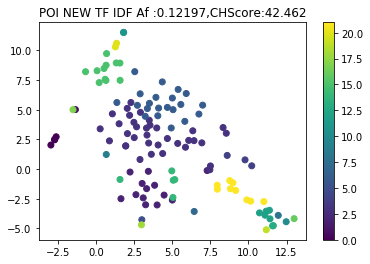

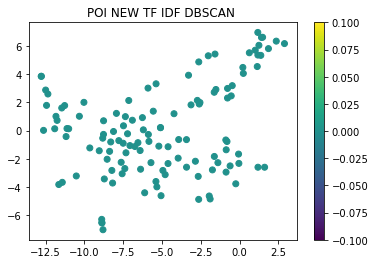

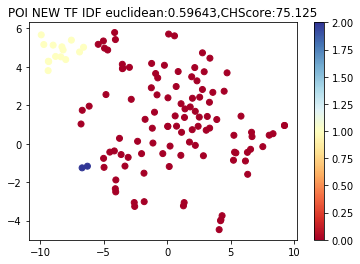

In [10]:
# What is the resutl of clustering on poi_tf_idf
# Use different kinds of clutering 
# Affinity propagation
af=sklearn.cluster.AffinityPropagation()
poi_tf_idf_labels=af.fit_predict(poi_tf_idf)
print(len(list(set(poi_tf_idf_labels))))
poi_tsne=TSNE(n_components=2,learning_rate=200).fit_transform(poi_tf_idf)
plt.figure(0)
plt.scatter(poi_tsne[:,0],poi_tsne[:,1],c=poi_tf_idf_labels)
plt.title('POI NEW TF IDF Af :{:.5f},CHScore:{:.3f}'.format(sklearn.metrics.silhouette_score(poi_tf_idf,poi_tf_idf_labels),
                                                       sklearn.metrics.calinski_harabaz_score(poi_tf_idf,poi_tf_idf_labels)))
plt.colorbar()
plt.savefig('fig/poi_new_tf_idf_af_default.pdf')
# DBSCAN
db=sklearn.cluster.DBSCAN(metric='cosine',min_samples=1)
poi_tf_idf_labels_db=db.fit_predict(poi_tf_idf)
print(len(list(set(poi_tf_idf_labels_db))))
poi_tsne=TSNE(n_components=2,learning_rate=200).fit_transform(poi_tf_idf)
plt.figure(1)
plt.scatter(poi_tsne[:,0],poi_tsne[:,1],c=poi_tf_idf_labels_db)
plt.title('POI NEW TF IDF DBSCAN ')
plt.colorbar()
plt.savefig('fig/poi_new_tf_idf_dbscan_cosine_min5.pdf')
# AgglomerativeClustering
tint_n_clusters=3
tint_linkage='ward'
tint_affinity='euclidean'
agglo=sklearn.cluster.AgglomerativeClustering(n_clusters=tint_n_clusters,linkage=tint_linkage,affinity=tint_affinity)
poi_tf_idf_labels_agg=agglo.fit_predict(np.row_stack(poi_tf_idf))
tsne_tint_1=TSNE(n_components=2,learning_rate=100).fit_transform(poi_tf_idf)

plt.figure(2)
plt.scatter(tsne_tint_1[:,0],tsne_tint_1[:,1],c=poi_tf_idf_labels_agg,cmap=plt.cm.get_cmap('RdYlBu'))
plt.colorbar()
plt.title('POI NEW TF IDF '+tint_affinity+':{:.5f},CHScore:{:.3f}'.format(sklearn.metrics.silhouette_score(poi_tf_idf,poi_tf_idf_labels_agg,metric=tint_affinity),
                                                       sklearn.metrics.calinski_harabaz_score(poi_tf_idf,poi_tf_idf_labels_agg)))
figname='fig/poi_new_tf_idf_agg_clusters_'+str(tint_n_clusters)+'-link_'+tint_linkage+'_affin_'+tint_affinity+'.pdf'
plt.savefig(figname)
plt.show()

Converged after 36 iterations.
13
1


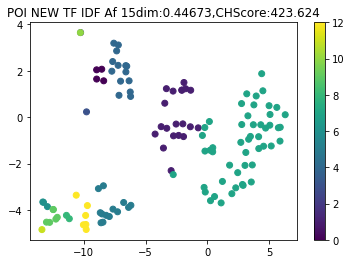

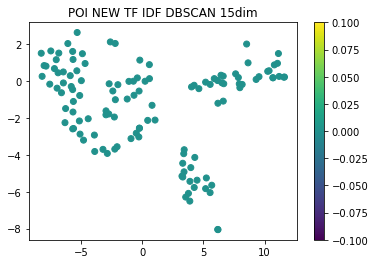

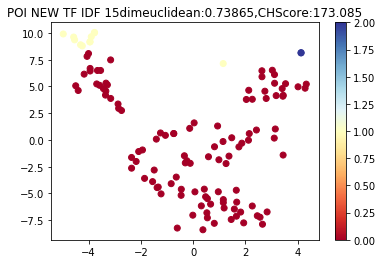

In [141]:
# What is the resutl of clustering on poi_tf_idf_svd
# Use different kinds of clutering 
# Affinity propagation
af=sklearn.cluster.AffinityPropagation(damping=0.5,verbose=True)
poi_tf_idf_svd_labels=af.fit_predict(poi_tf_idf_svd)
print(len(list(set(poi_tf_idf_svd_labels))))
poi_tsne=TSNE(n_components=2,learning_rate=200).fit_transform(poi_tf_idf_svd)
plt.figure(0)
plt.scatter(poi_tsne[:,0],poi_tsne[:,1],c=poi_tf_idf_svd_labels)
plt.title('POI NEW TF IDF Af 15dim:{:.5f},CHScore:{:.3f}'.format(sklearn.metrics.silhouette_score(poi_tf_idf_svd,poi_tf_idf_svd_labels),
                                                       sklearn.metrics.calinski_harabaz_score(poi_tf_idf_svd,poi_tf_idf_svd_labels)))
plt.colorbar()
plt.savefig('fig/poi_new_tf_idf_svd_15d_damp0.5_af_default.pdf')
# DBSCAN
db=sklearn.cluster.DBSCAN(metric='cosine',min_samples=1)
poi_tf_idf_svd_labels_db=db.fit_predict(poi_tf_idf_svd)
print(len(list(set(poi_tf_idf_svd_labels_db))))
poi_tsne=TSNE(n_components=2,learning_rate=200).fit_transform(poi_tf_idf_svd)
plt.figure(1)
plt.scatter(poi_tsne[:,0],poi_tsne[:,1],c=poi_tf_idf_svd_labels_db)
plt.title('POI NEW TF IDF DBSCAN 15dim')
plt.colorbar()
plt.savefig('fig/poi_new_tf_idf_svd_15d_dbscan_cosine_min5.pdf')
# AgglomerativeClustering
tint_n_clusters=3
tint_linkage='ward'
tint_affinity='euclidean'
agglo=sklearn.cluster.AgglomerativeClustering(n_clusters=tint_n_clusters,linkage=tint_linkage,affinity=tint_affinity)
poi_tf_idf_svd_labels_agg=agglo.fit_predict(np.row_stack(poi_tf_idf_svd))
tsne_tint_1=TSNE(n_components=2,learning_rate=100).fit_transform(poi_tf_idf_svd)

plt.figure(2)
plt.scatter(tsne_tint_1[:,0],tsne_tint_1[:,1],c=poi_tf_idf_svd_labels_agg,cmap=plt.cm.get_cmap('RdYlBu'))
plt.colorbar()
plt.title('POI NEW TF IDF 15dim'+tint_affinity+':{:.5f},CHScore:{:.3f}'.format(sklearn.metrics.silhouette_score(poi_tf_idf_svd,poi_tf_idf_svd_labels_agg,metric=tint_affinity),
                                                       sklearn.metrics.calinski_harabaz_score(poi_tf_idf_svd,poi_tf_idf_svd_labels_agg)))
figname='fig/poi_new_tf_idf_svd_15d_3c_agg_clusters_'+str(tint_n_clusters)+'-link_'+tint_linkage+'_affin_'+tint_affinity+'.pdf'
plt.savefig(figname)
plt.show()

5

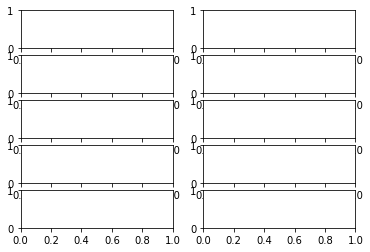

In [100]:
cnt=0
for i in range(len(list(set(poi_tf_idf_svd_labels)))):
    idx=(poi_tf_idf_svd_labels==i)
    if np.sum(idx)>1 :
        cnt+=1

#subplts=int(str(np.ceil(cnt/2))+'21')
subplts=int(str(int(np.ceil(cnt/2)))+'21')
fig,subplts=plt.subplots(5,2)
len(subplts)

22
Station list of cluster 0:  (['STN Bartley', 'STN Kallang', 'STN Yio Chu Kang', 'STN Tai Seng'], [['CC'], ['EW'], ['NS'], ['CC']]) 

Station list of cluster 1:  (['STN Bukit Panjang', 'STN Choa Chu Kang', 'STN Pioneer', 'STN Woodlands', 'STN Serangoon', 'STN Boon Keng', 'STN Lakeside', 'STN Bukit Batok', 'STN Compassvale', 'STN Phoenix', 'STN Jurong East', 'STN Bukit Gombak', 'STN Senja', 'STN Braddell', 'STN Pending', 'STN Potong Pasir', 'STN Botanic Gardens', 'STN Chinese Garden', 'STN Dakota', 'STN Buona Vista'], [['DT', 'BP'], ['NS', 'JS', 'BP'], ['EW'], ['NS', 'TE'], ['NE', 'CC'], ['NE'], ['EW'], ['NS'], ['SE'], ['BP'], ['NS', 'EW', 'JE'], ['NS'], ['BP'], ['NS'], ['BP'], ['NE'], ['CC', 'DT'], ['EW'], ['CC'], ['EW', 'CC']]) 

Station list of cluster 4:  (['STN Paya Lebar', 'STN Eunos', 'STN Kovan', 'STN Lorong Chuan', 'STN Queenstown', 'STN Lavender', 'STN Redhill', 'STN Marymount', 'STN Kembangan', 'STN MacPherson', 'STN Pasir Panjang', 'STN Farmway', 'STN Joo Koon', 'STN Thang

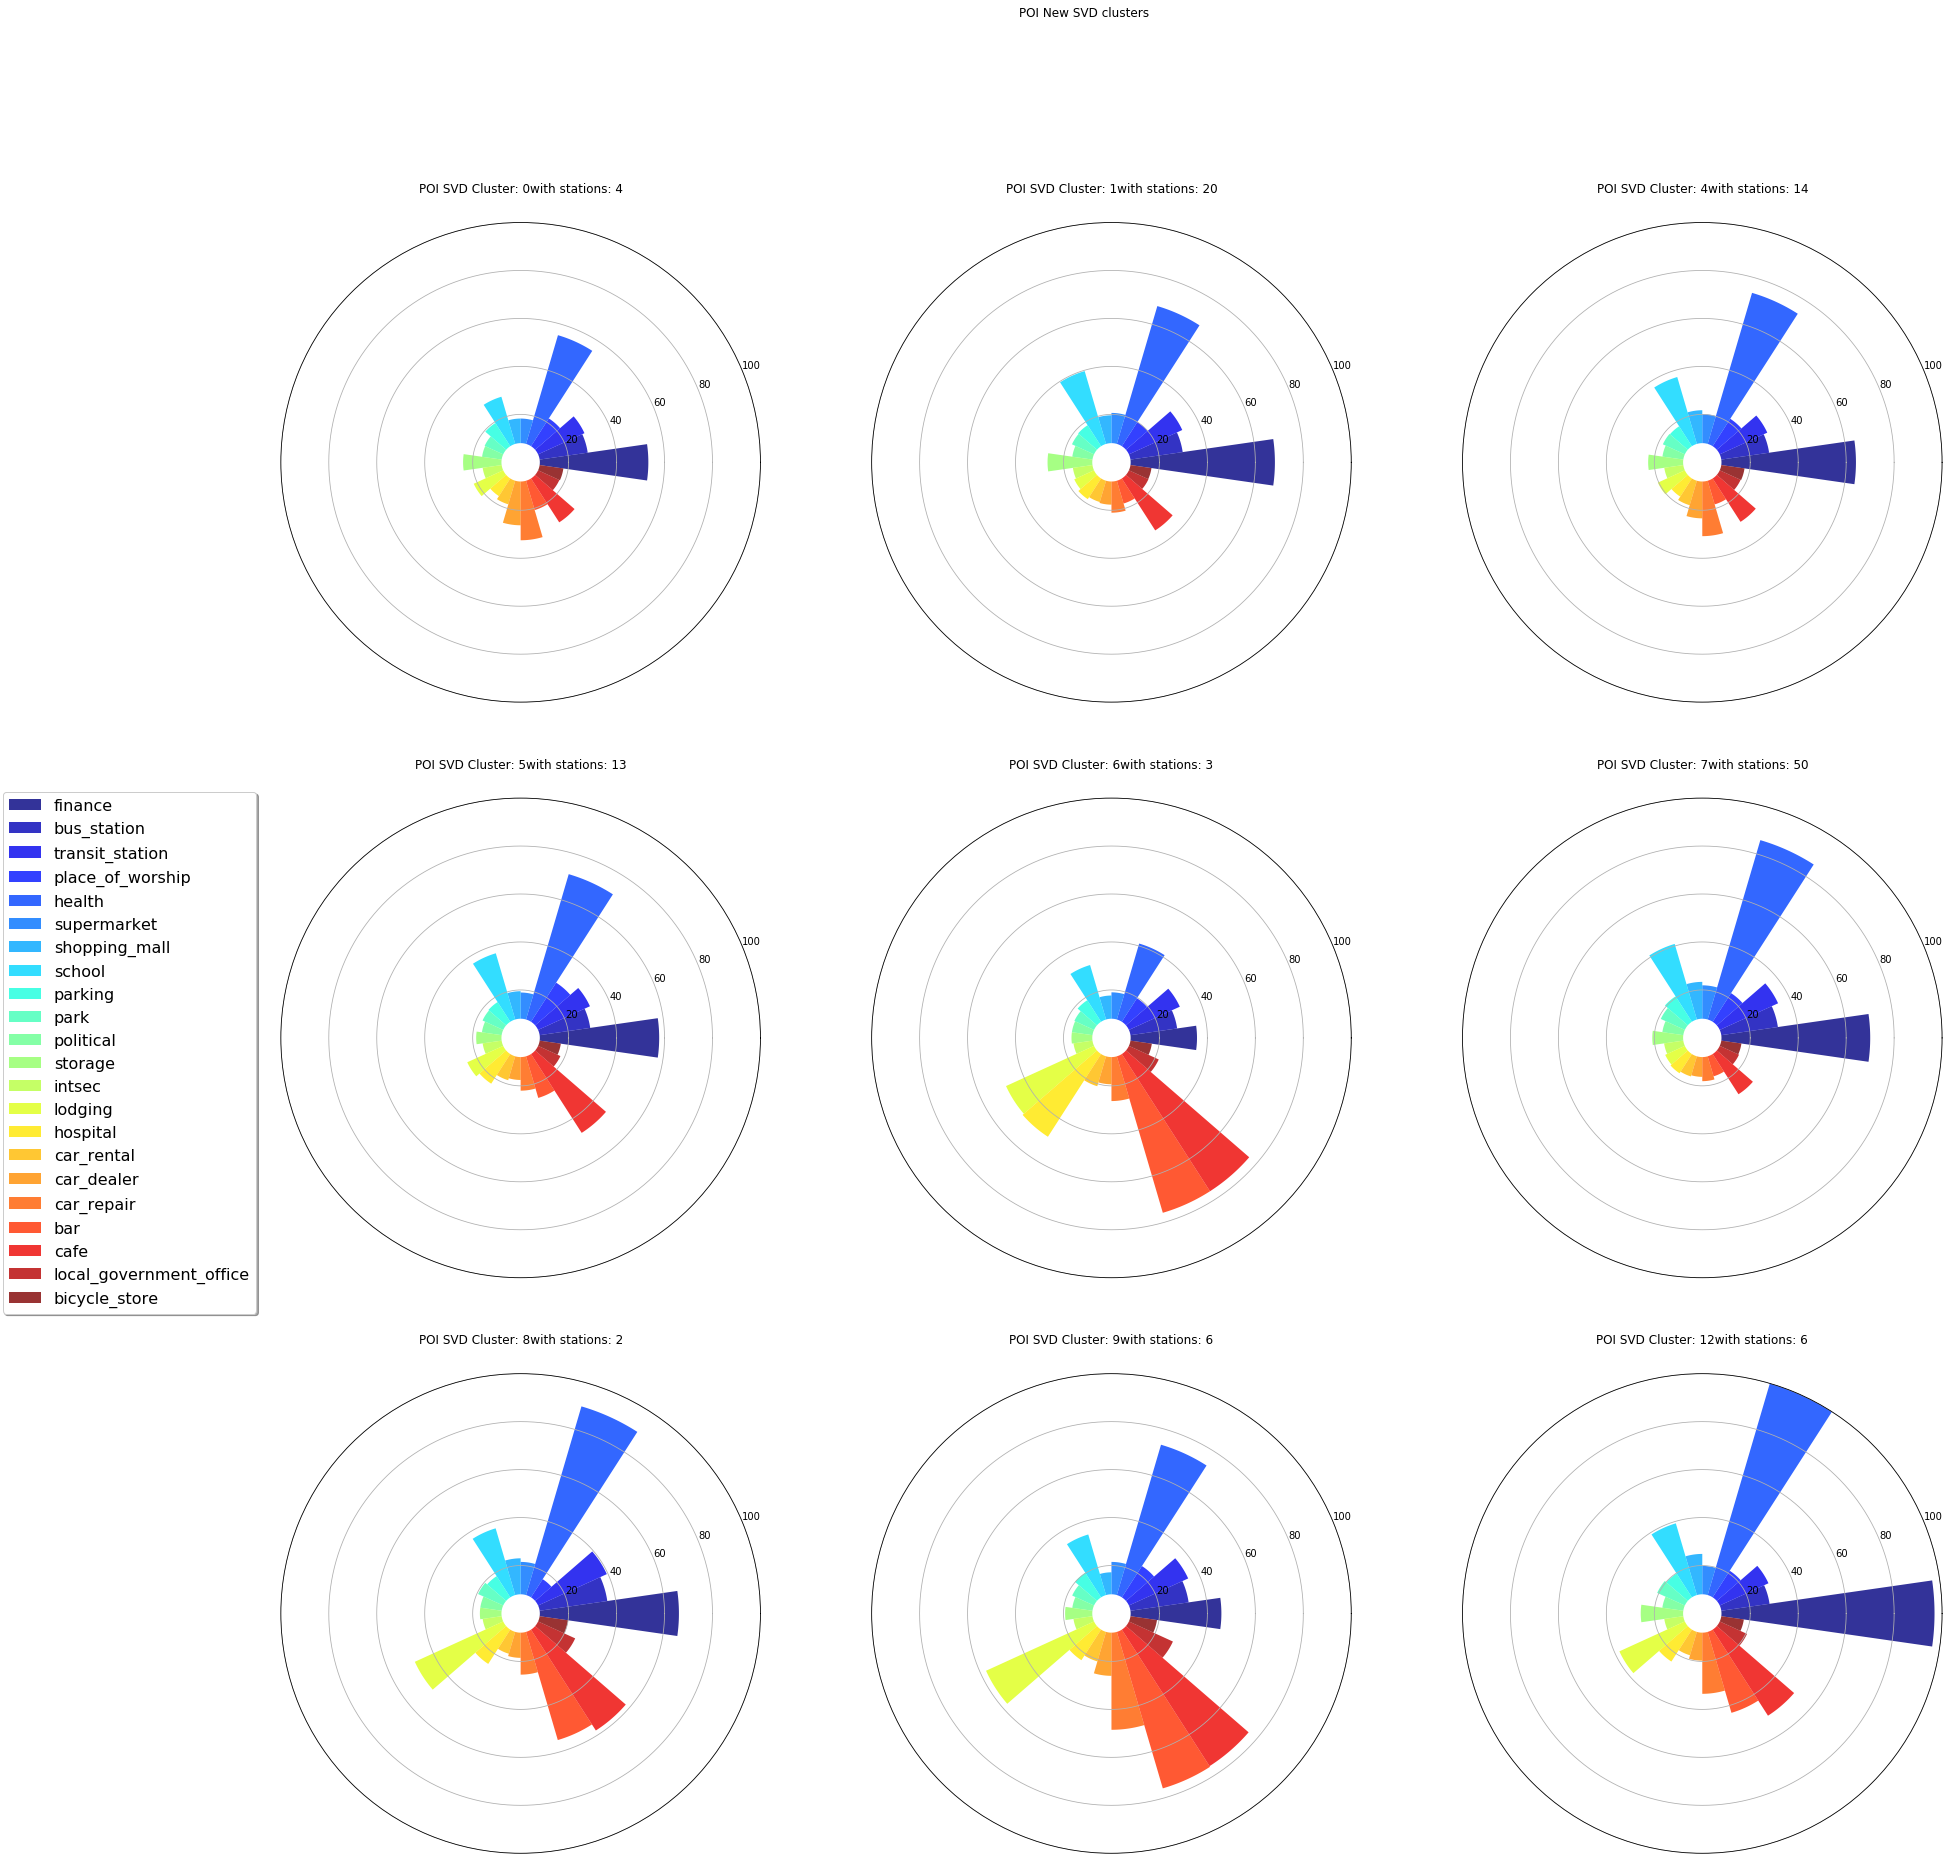

In [185]:
# What is the distribution of different POIs clusters from AF results?
print(np.shape(poi_mat)[1])
bottom = 8
N=len(poi_selected)
theta = np.linspace(0.0, 2 * np.pi, N , endpoint=False)
width = (2*np.pi) / (N)

#subplts=int(str(int(np.ceil(cnt/2)))+'21')
#ax = plt.subplot(111, polar=True)
#ax = plt.subplot(nrows=10,ncols=1, polar=True)

fig=plt.figure(0,figsize=(30,30))
subplts=331
for i in range(len(list(set(poi_tf_idf_svd_labels)))):
    idx=(poi_tf_idf_svd_labels==i)
    if np.sum(idx)>1 :
        #plt.figure(i,figsize=(10,10))
        #c=np.mean(station_POI_Intsec[poi_selected][idx])
        c=np.mean(poi_mat[idx],axis=0)
        c+=bottom
        #plt.bar(range(len(c)),c)
        #plt.xticks(list(range(len(c))),poi_selected)
        ax = plt.subplot(subplts, polar=True)

        bars = ax.bar(theta,c.tolist()[0], width=width, bottom=bottom)
        ax.set_rlim(0,100)
        
        # Use custom colors and opacity
        for r, bar in zip(theta, bars):
            bar.set_facecolor(plt.cm.jet(r/6))
            bar.set_alpha(0.8)
        #ax.legend(bars,poi_selected,loc='upper center', bbox_to_anchor=(0,0.8),  shadow=True)
        #plt.xlabel('POI')
        #plt.ylabel('Mean POI frequency')
        #plt.axis('off')
        ax.grid(True)
        ax.set_xticks([])
        ax.set_title('POI SVD Cluster: '+str(i)+'with stations: '+str(len(getStationNames(np.where(idx)[0])[0])))
        #plt.title('POI SVD Cluster: '+str(i))
        #plt.savefig('fig/poi_new/poi_svd_sluster {:}.png'.format(i))
        subplts+=1
        print('Station list of cluster {:}: '.format(i),getStationNames(np.where(idx)[0])[1:],'\n')
    else:
        continue
plt.rc('legend',fontsize=16) # using a size in points
fig.suptitle('POI New SVD clusters')
fig.legend(bars,poi_selected,loc='upper center', bbox_to_anchor=(0.06,0.5),  shadow=True, )
plt.savefig('fig/poi_new/poi_svd_slusters.png')

In [184]:
a=list(getStationNames(np.where(idx)[0]))
a[]

['STN Bartley', 'STN Kallang', 'STN Yio Chu Kang', 'STN Tai Seng']

In [161]:
subplts

340

## Analyze spatial features
['total_flow',
 'adu_dis',
 'chd_dis',
 'sen_dis',
 'ori_dist',
 'des_dist',
 'ori_runtime',
 'des_runtime']
 
 maybe it should be reduced into 5 vectors for better understanding the features, these analysis serves the metadata of mobility analysis in the above
 
 Consider adu,sen,chd/total as 3 dimensions and dis/run time (<1)  as another 2 features to better understand the semantics of stations

In [184]:
# Obtain the metadata
'''
spa_mat[spa_mat[:,0]==0,0]=1
np.std(spa_mat[:,1:4]/(spa_mat[:,0].reshape(-1,1)))
spa_mat_meta_1=spa_mat[:,1:4]/(spa_mat[:,0].reshape(-1,1))

spa_mat[spa_mat[:,6]==0,4:6]=0
spa_mat[spa_mat[:,7]==0,4:6]=0
spa_mat[spa_mat[:,6]==0,6]=1
spa_mat[spa_mat[:,7]==0,7]=1
spa_mat_meta_2=(spa_mat[:,4:6]/spa_mat[:,6:])
idx=np.where((spa_mat[:,4:6]/spa_mat[:,6:])>1)
spa_mat_meta_2[idx[0][0]]=np.mean(spa_mat_meta_2,axis=0)

spa_mat_meta=np.column_stack((spa_mat_meta_1,spa_mat_meta_2))
del spa_mat_meta_1,spa_mat_meta_2
joblib.dump(spa_mat_meta,'spa_mat_meta.asv')
'''

['spa_mat_meta.asv']

Did not converge
141


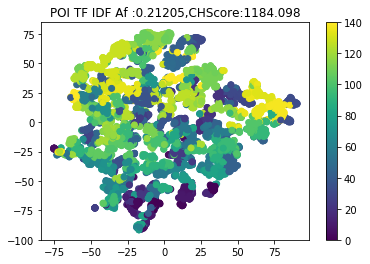

In [187]:
af=sklearn.cluster.AffinityPropagation(damping=0.5,verbose=True,max_iter=500)
spa_mat_meta_labels=af.fit_predict(spa_mat_meta)
print(len(list(set(spa_mat_meta_labels))))
poi_tsne=TSNE(n_components=2,learning_rate=200).fit_transform(spa_mat_meta)
plt.figure(0)
plt.scatter(poi_tsne[:,0],poi_tsne[:,1],c=spa_mat_meta_labels)
plt.title('POI TF IDF Af :{:.5f},CHScore:{:.3f}'.format(sklearn.metrics.silhouette_score(spa_mat_meta,spa_mat_meta_labels),
                                                       sklearn.metrics.calinski_harabaz_score(spa_mat_meta,spa_mat_meta_labels)))
plt.colorbar()
plt.savefig('fig/spa_mat_meta_2_damp0.5_af_default.pdf')

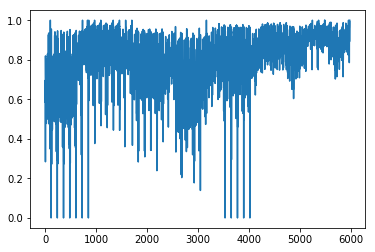

In [198]:
plt.plot(spa_mat_meta[:,0])

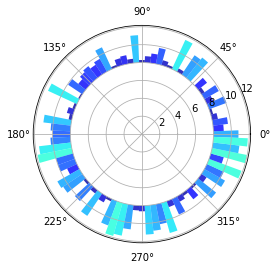

In [239]:
N = 80
bottom = 8
max_height = 4

theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = max_height*np.random.rand(N)
width = (2*np.pi) / N

ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)

# Use custom colors and opacity
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.jet(r / 10.))
    bar.set_alpha(0.8)

plt.show()

In [269]:
c

30.419642857142858